# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [7]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
from scipy.stats import trim_mean
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
import sklearn
from sklearn.cluster import KMeans
import colorsys

# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [8]:
#Plotting Related Options
histPlot = False          #Plots the parameter values for all iterations at each TI - one plot per iteration
stdPlot = True              #Plots the standard deviation of each parameter per TI
CN_estParams = True               #Plots the condition numbers per TI
denPlot = False              #Plot all recreated estimated signals against the true signal 
denPlotNoise = False         #Plots all noisy signals against the true data for comparison

#Process Related Options
dModel = True               #This option enables for using the d1 and d2 based model
bothTI = True               #Ensures that the code looks at both nullpoints rather than just the first one
onlyT1 = False            #Ignores the backbone if selected
intEnds = True
if onlyT1:
    assert(not bothTI)
randStart = False            #Enables the multistart option for curve_fit
RSS_noise_opt = True        #Evaluates RSS relative to noise rather than RSS relative to the true curve

# Initialize Parameters and Arrays

In [9]:
#Assumed echo time points
TE_series = np.linspace(8, 512, 64) #ms units
assert(TE_series[-1] == 512)
assert(np.mean(np.diff(TE_series))==8)

#Parameters that dictate process related features
iterCount = 500 #number of iterations that curveFit is applied
SNR = 1000
noiseSigma = 1/SNR

#Curve Fit Trials - how many times do we run curve_fit before we take a parameter fit solution
if randStart:
    randStart_trials = 10
else:
    randStart_trials = 1

######All Fixed parameters for code
#Parameters held constant
c1 = 0.5
c2 = 0.5
T21 = 45
T22 = 200
T11 = 600
T12 = 1200

initParams = np.array([T11, T12, c1, c2, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Zoom Fits range - used for plots
rad = 15 #standard unit radius around the zoom fits

#Information determing TI range
genResolution = 20 #30
nullResolution = 0.5
nullRadius = 20  #20

#Preparing TI array to loop through
TI1star = np.log(2)*T11
TI2star = np.log(2)*T12

#TI array bounds
TI_lowBound = TI1star*2//3
if bothTI:
    TI_highBound = TI2star*4//3
else:
    TI_highBound = np.mean([TI1star,TI2star])

standard_array = np.arange(-nullRadius,nullRadius+0.01,nullResolution)
if intEnds:
    TI1_array = np.floor(TI1star) + standard_array
    TI2_array = np.floor(TI2star) + standard_array
else:
    TI1_array = TI1star + standard_array
    TI2_array = TI2star + standard_array

gen_array = np.arange(TI_lowBound, TI_highBound, genResolution)

if bothTI:
    TI_array = np.concatenate((gen_array, TI1_array, TI2_array))
else:
    if onlyT1:
        TI_array = TI1_array
    else:
        TI_array = np.concatenate((gen_array, TI1_array))
TI_array = np.unique(TI_array)
TI_array.sort()

#Initializing all the storage matrices
#Storing all strings associated with titles
MonoTitle = ['d', 'T2']
ParamTitle_4p = ['d1', 'd2', 'T21', 'T22']
ParamTitle_6p = ['T11','T12','c1','c2','T21','T22']

#List estimated Param names
if dModel:
    estParams = ParamTitle_4p
else:
    estParams = ParamTitle_6p[2:]

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p) #Builds the list of parametes used to generate the original data

if dModel:
    fitType = "4p in 4p eqn"
else:
    fitType = "4p in 6p eqn"

#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) +" :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\n' + r'$\alpha$'+ ' Radius = ' + str(nullRadius) + " :: TI range = (" + "{:.2f}".format(TI_array[0]) + "," + "{:.2f}".format(TI_array[-1]) + 
            ') :: Points: ' + str(np.size(TI_array)) + " :: Starts " + str(randStart_trials) +
            '\n' + fitType)

# Initialize Zeroed Arrays

In [10]:
#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(estParams)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])

#Storing all the estimated signals for each iteration and TI array
noiseSigStore = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])

#All error related matrices
RSS_Store_2E = np.zeros([np.size(TI_array),iterCount])
RSS_Noise_Store_2E = np.zeros([np.size(TI_array),iterCount])
errStore_2E = np.zeros([np.size(TI_array),iterCount])
RSS_Store_1E = np.zeros([np.size(TI_array),iterCount])
RSS_Noise_Store_1E = np.zeros([np.size(TI_array),iterCount])
errStore_1E = np.zeros([np.size(TI_array),iterCount])

#Condition number related matrix
if CN_estParams:
    if dModel:
        CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
    else:
        CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_6p)])

#Count Rulebreakers
numRuleBreak = np.zeros((np.size(TI_array),2))

# Define Functions

In [11]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22, TI_rescale = 1, TE_rescale = 1):
    [TE, T21, T22] = np.array([TE, T21, T22], dtype = 'object')/TE_rescale
    [TI, T11, T12] = np.array([TI, T11, T12], dtype = 'object')/TI_rescale
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dT11, dT12, dc1, dc2, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22, TE_rescale = 1):
    [TE, T21, T22] = np.array([TE, T21, T22], dtype = 'object')/TE_rescale
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

def check_param_order(popt):
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[-1] < popt[-2]): #We want by convention to make sure that T21 is <= T22
        for pi in range(np.size(popt)//2):
            p_hold = popt[2*pi]
            popt[2*pi] = popt[2*pi+1]
            popt[2*pi+1] = p_hold
    return popt

def add_noise(data,SNR):
    #returns a noised vector of data using the SNR given
    sigma = 1/SNR #np.max(np.abs(data))/SNR
    noise = np.random.normal(0,sigma,data.shape)
    noised_data = data + noise
    return noised_data

def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# Build Curve Fitting Dataset

In [12]:
#Looping through all TI values in the TI_array
for k in trange(np.size(TI_array)):

    TI = TI_array[k]

    true_d1 = d_value(TI, c1, T11)
    true_d2 = d_value(TI, c2, T12)

    realParams_4p = np.array([true_d1, true_d2, T21, T22])

    realParams = np.array([c1,c2,T21,T22])

    trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
    trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

    assert(np.allclose(trueDat,trueDat_4p))
        
    brokenRules_2E = 0
    brokenRules_1E = 0

    for i in range(iterCount):

        #Determining the noise and add noise to data
        noiseDat = add_noise(trueDat,SNR)

        noiseSigStore[k,i,:] = noiseDat

        #This should be compared to the lowest RSS to noise
        paramTrials_2E = np.zeros((randStart_trials, np.size(estParams)))
        paramTrials_1E = np.zeros((randStart_trials, np.size(MonoTitle)))
        RSS_trials_2E = np.ones(randStart_trials)*np.inf
        RSS_trials_1E = np.ones(randStart_trials)*np.inf

        for tri in range(randStart_trials):
              
            #Running all the biexponential fits
            try:
                ub = (1,1,T2_bound,T2_bound)

                if dModel:
                    lb = (-1,-1,0,0)
                    if randStart:
                        init_p = tuple(np.add(np.subtract(ub,lb)*np.random.uniform(0,1,np.size(lb)),lb))
                    else:
                        init_p = realParams_4p

                    popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                    popt_2E = check_param_order(popt_2E)
                    est_Sig_2E = S_biX_4p(TE_series, *popt_2E)
                
                else:
                    lb = (0,0,0,0)
                    if randStart:
                        init_p = tuple(np.add(np.subtract(ub,lb)*np.random.uniform(0,1,np.size(lb)),lb))
                    else:
                        init_p = realParams
                    
                    popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_6p(t_dat,TI,T11,T12,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                    popt_2E = check_param_order(popt_2E)
                    est_Sig_2E = S_biX_6p(TE_series,TI,T11,T12,*popt_2E)
                
                paramTrials_2E[tri,:] = popt_2E
                RSS_trials_2E[tri] = np.sum((noiseDat - est_Sig_2E)**2)

            except Exception as e:
                print("Biexponential")
                print(e)
                brokenRules_2E += 1
                continue

            #Running all the monoexponential fits
            try:
                lb = (-1,0)
                ub = (1,T2_bound)
                if randStart:
                    init_p = tuple(np.add(np.subtract(ub,lb)*np.random.uniform(0,1,np.size(lb)),lb))
                else:
                    init_p = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

                popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                paramTrials_1E[tri,:] = popt_1E
                est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
                RSS_trials_1E[tri] = np.sum((noiseDat - est_Sig_1E)**2)

            except Exception as e:
                print("Monoexponential")
                print(e)
                brokenRules_1E += 1
                continue

        #Identify the index of the lowest RSS
        minRSS_2E_index = np.argmin(RSS_trials_2E)
        minRSS_1E_index = np.argmin(RSS_trials_1E)

        #This step prevents rewriting the code anymore than I already have - sets the minimum trial as the optimal parameters
        popt_2E = paramTrials_2E[minRSS_2E_index,:]
        popt_1E = paramTrials_1E[minRSS_1E_index,:]

        paramStore_2E[k,i,:] = popt_2E
        paramStore_1E[k,i,:] = popt_1E

        #Calculate Condition Number
        if CN_estParams:
            if dModel:
                B = Jacobian_4p(TE_series, *popt_2E)
            else:
                B = Jacobian_6p(TE_series, TI, T11, T12, *popt_2E) 
            covP = np.dot(B.T,B) #*noiseSigma**2

            CN_params = np.reshape(np.diag(covP),(1,-1))
            CNStore[k,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        if dModel:
            est_Sig_2E = S_biX_4p(TE_series, *popt_2E)
        else:
            est_Sig_2E = S_biX_6p(TE_series,TI,T11,T12,*popt_2E)
        RSS_Store_2E[k,i] = np.sum((trueDat - est_Sig_2E)**2)
        RSS_Noise_Store_2E[k,i] = np.sum((noiseDat - est_Sig_2E)**2)
        errStore_2E[k,i] = np.linalg.norm(trueDat - est_Sig_2E, ord = 2)
        sigStore_2E[k,i,:] = est_Sig_2E

        #Calculate Residual Sum of Squares (RSS) of 1E
        est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
        RSS_Store_1E[k,i] = np.sum((trueDat - est_Sig_1E)**2)
        RSS_Noise_Store_1E[k,i] = np.sum((noiseDat - est_Sig_1E)**2)
        errStore_1E[k,i] = np.linalg.norm(trueDat - est_Sig_1E, ord = 2)
        sigStore_1E[k,i,:] = est_Sig_1E


    numRuleBreak[k,0] = brokenRules_2E
    numRuleBreak[k,1] = brokenRules_1E


100%|██████████| 200/200 [19:39<00:00,  5.90s/it]


# Plotting

### Histogram of Parameters

In [13]:
if histPlot:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:].copy()
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Parameter Histogram" + details)

        TI = TI_array[k]

        if dModel:
            true_d1 = d_value(TI, c1, T11)
            true_d2 = d_value(TI, c2, T12)

            plotParams = (true_d1, true_d2, T21, T22)
        else:
            plotParams = realParams
        
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = estParams[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParams[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=plotParams[2*ii], linewidth=1, label= 'True ' + estParams[2*ii], color='b')
            ax[ii].axvline(x=plotParams[2*ii+1], linewidth=1, label= 'True ' + estParams[2*ii+1], color='g')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParams[2*ii], color='b', ls = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParams[2*ii+1], color='g', ls = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + estParams[2*ii] + '=' + str(round(plotParams[2*ii],2)) + ' :: ' 
                        'True ' + estParams[2*ii+1] + '=' + str(round(plotParams[2*ii+1],2)))
        plt.show()

### dModel Specific Parameter Histogram

In [14]:
if histPlot and dModel:
    for k in range(paramStore_2E.shape[0]):
        paramData = paramStore_2E[k,:,:].copy()
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        fig.suptitle("Calculated Parameter Histogram" + details)

        estParamsTemp = ParamTitle_6p[2:np.size(ParamTitle_6p)]

        TI = TI_array[k]

        if TI==TI1star or TI==TI2star:
            fig.suptitle("Skipped nullpoint")
            continue

        paramData[:,0] = paramData[:,0]/(1-2*np.exp(-TI/T11)) #calculating all of the c1 values
        paramData[:,1] = paramData[:,1]/(1-2*np.exp(-TI/T12)) #calculating all of the c2 values
        
        for ii in range(2):
            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramData[:,2*ii], bins=20, color='b', label = estParamsTemp[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramData[:,2*ii+1], bins=20, color='g', label = estParamsTemp[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + estParamsTemp[2*ii], color='b')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' +estParamsTemp[2*ii+1], color='g')
            ax[ii].axvline(x=np.mean(paramData[:,2*ii]), linewidth=1, label= 'Avg ' + estParamsTemp[2*ii], color='b', ls = "--")
            ax[ii].axvline(x=np.mean(paramData[:,2*ii+1]), linewidth=1, label= 'Avg ' + estParamsTemp[2*ii+1], color='g', ls = "--")
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\n' + r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + estParamsTemp[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + estParamsTemp[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        plt.show()

### Density Plot of Fitted Signals

In [15]:
if denPlot:
    for k in range(paramStore_2E.shape[0]):

        TI = TI_array[k]
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        fig, ax = plt.subplots(1,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + details + 
                        '\n' + r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))
        
        for rep in range(iterCount):
            ax[0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0].set_xlabel("TE")
        ax[1].set_xlabel("TE")
        ax[0].set_ylabel("Signal")
        ax[1].set_ylabel("Signal")
        ax[0].set_title("Biexponential Fits")
        ax[1].set_title("Monoexponential Fits")

        plt.show()

### Density Plot of Noisy Signals

In [16]:
if denPlotNoise:
    for k in range(paramStore_2E.shape[0]):

        TI = TI_array[k]
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        fig = plt.figure(figsize=(7,6), tight_layout=True)
        
        for rep in range(iterCount):
            plt.plot(TE_series, noiseSigStore[k,rep,:], color='r', alpha = 0.5)

        plt.plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        plt.xlabel("TE")
        plt.ylabel("Signal")
        plt.title("Noisy Signals" + details + 
                        '\n'+ r'$\alpha_1$'+ ' = ' + "{:.3f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.3f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI,2)))


        plt.show()

##### Identify T11 Nullpoint Local Minima

In [17]:
localMinima = False

if localMinima:
    num_clusters = 3

    TI1_index = np.where(TI_array == TI1star)[0][0]

    RSS_data = np.reshape(RSS_Store_2E[TI1_index,:],(-1,1))

    kmeans = KMeans(n_clusters = num_clusters).fit(RSS_data)

    kmeans_return = kmeans.labels_
    kmeans_centers = kmeans_centers = np.array(kmeans.cluster_centers_)

    trueDat = S_biX_6p(TE_series, TI_array[TI1_index], T11, T12, c1, c2, T21, T22)

    fig = plt.figure(figsize=(7,6), tight_layout=True)
        
    for rep in range(iterCount):
        redC = kmeans_return[rep]/(num_clusters-1)
        colorVal = (redC, 0, 1)
        plt.plot(TE_series, sigStore_2E[TI1_index,rep,:], color=colorVal, alpha = 0.5)

    plt.plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
    plt.xlabel("TE")
    plt.ylabel("Signal")
    plt.title("Separated Minimums" + details + 
                    '\n' + r'$\alpha_1$'+ ' = ' + "{:.2f} :: ".format(TI/TI1star) + r'$\alpha_2$'+ ' = ' + "{:.2f} ".format(TI/TI2star) + ' :: TI = ' + str(round(TI_array[TI1_index],2)))

    plt.show()

    estParamStrList = ', '.join(x for x in estParams)
    pListShort = ', '.join(str(x) for x in round_Params[2:6])

    for ii in range(num_clusters):
        cluster = paramStore_2E[TI1_index,:,:]
        cluster = cluster[(kmeans_return == ii),:]
        cluster_avg = np.mean(cluster,axis=0)
        cluster_avg_str = ', '.join(str(np.round(x,2)) for x in cluster_avg)
        cluster_std = np.std(cluster,axis=0)
        cluster_std_str = ', '.join(str(np.round(x,2)) for x in cluster_std)

        print("For RSS Center = " + str(np.round(kmeans_centers[ii],2)) + " :: num Points = " + str(cluster.shape[0]) +
        '\n' + estParamStrList + ' true = ' + pListShort +
        '\n' + estParamStrList + ' averages = ' + cluster_avg_str + 
        '\n' + estParamStrList + ' standard deviation = ' + cluster_std_str + '\n\n')


    

### Standard Deviation

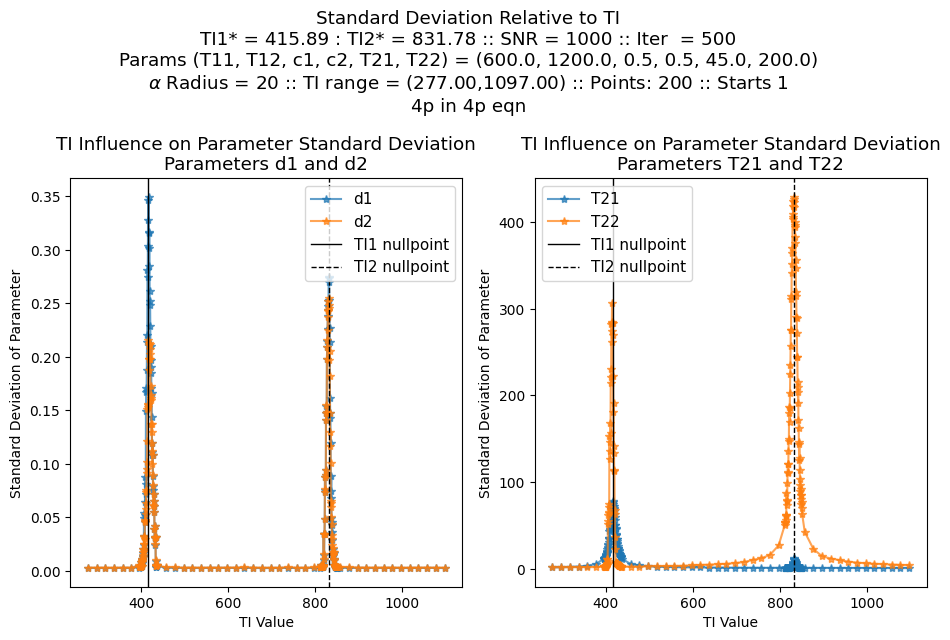

In [18]:
stdStore = np.std(paramStore_2E, axis = 1)
std2Store = np.var(paramStore_2E, axis = 1)**(1/2)
assert(np.all(np.isclose(stdStore,std2Store)))
mono_std = np.std(paramStore_1E, axis = 1)

if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    plt.rc('font', size = 11)
    fig.suptitle('Standard Deviation Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7, marker = "*")
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = "*")
        # ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        if bothTI:
            ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()

##### Official STD Figure

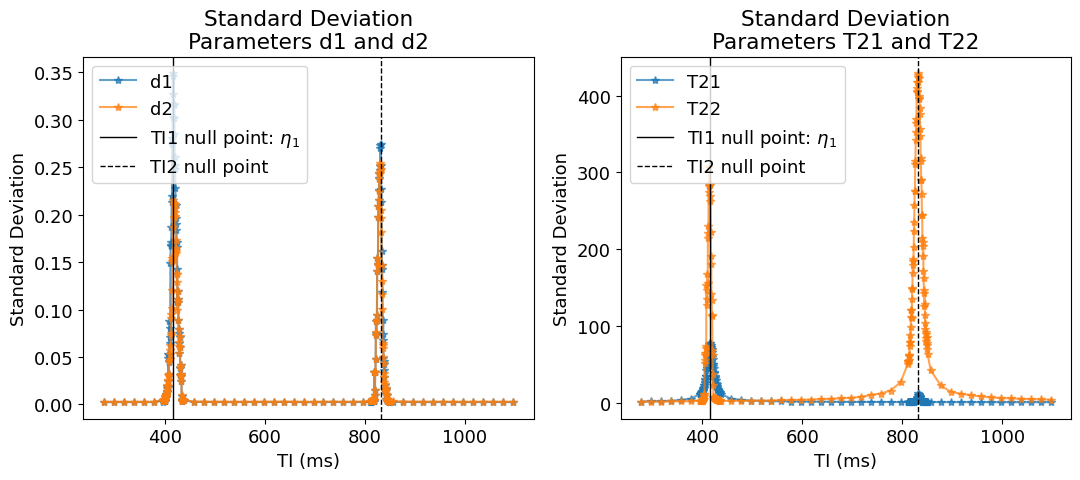

In [19]:
if stdPlot:
    plt.rc('font', size = 13)
    fig, ax = plt.subplots(1,2, figsize=(11,5), tight_layout=True)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = estParams[2*i], alpha = 0.7, marker = '*')
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7, marker = '*')
        # ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= r'TI1 null point: $\eta_1$', color='k')
        if bothTI:
            ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 null point', color='k', ls = '--')
        ax[i].set_xlabel('TI (ms)')
        ax[i].set_ylabel('Standard Deviation')
        ax[i].set_title('Standard Deviation' + '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()

### Effective-Condition Number Plots --- Variance Plots

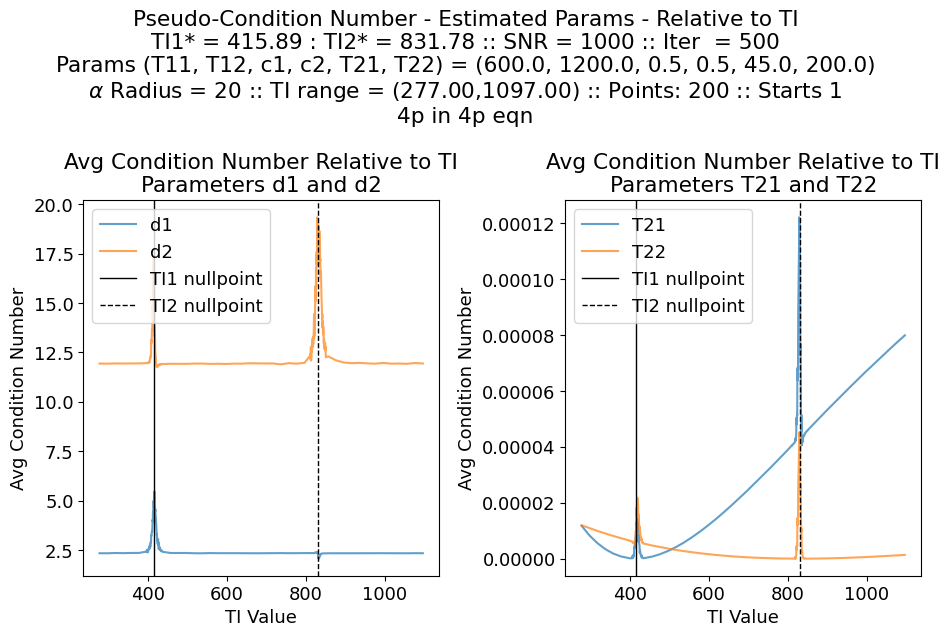

C:\Users\griff\AppData\Local\Temp\ipykernel_5004\46572566.py:21: RuntimeWarning: divide by zero encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
C:\Users\griff\AppData\Local\Temp\ipykernel_5004\46572566.py:21: RuntimeWarning: invalid value encountered in divide
  CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run


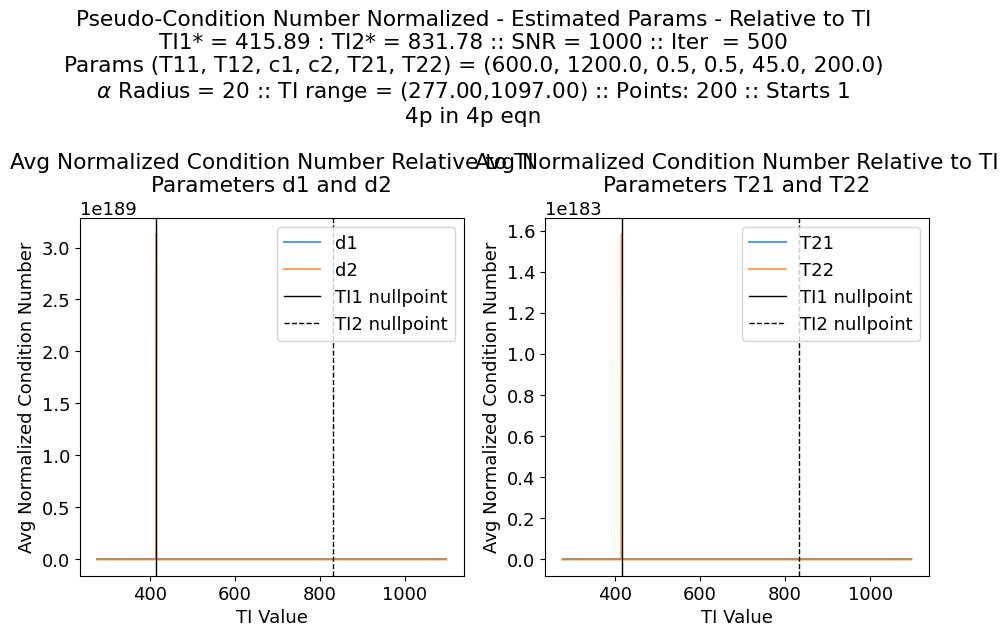

In [20]:
if CN_estParams:
    avgCNStore = np.mean(CNStore, axis = 1)


    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Pseudo-Condition Number - Estimated Params - Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,avgCNStore[:,2*i], label = estParams[2*i], alpha = 0.7)
        ax[i].plot(TI_array,avgCNStore[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        if bothTI:
            ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Avg Condition Number')
        ax[i].set_title('Avg Condition Number Relative to TI' +
                            '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()


    CN_normalized = CNStore/np.min(CNStore, axis = 2, keepdims = True) #minimizes along the condition number for each run
    CN_normalized = np.mean(CN_normalized, axis = 1)


    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Pseudo-Condition Number Normalized - Estimated Params - Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array, CN_normalized[:,2*i], label = estParams[2*i], alpha = 0.7)
        ax[i].plot(TI_array, CN_normalized[:,2*i+1], label = estParams[2*i+1], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        if bothTI:
            ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Avg Normalized Condition Number')
        # ax[i].set_ylim([0,10])
        ax[i].set_title('Avg Normalized Condition Number Relative to TI' +
                            '\nParameters ' + estParams[2*i] + ' and ' + estParams[2*i+1])
        ax[i].legend()
    plt.show()

### Analytic Effective-Condition Number Plots

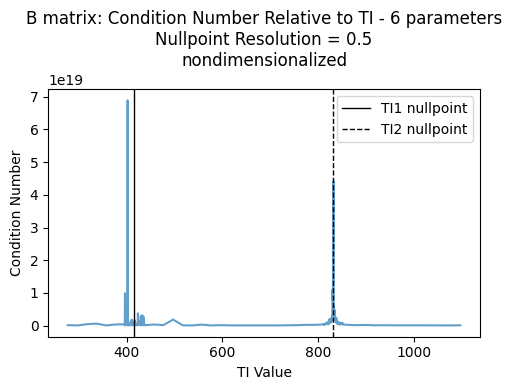

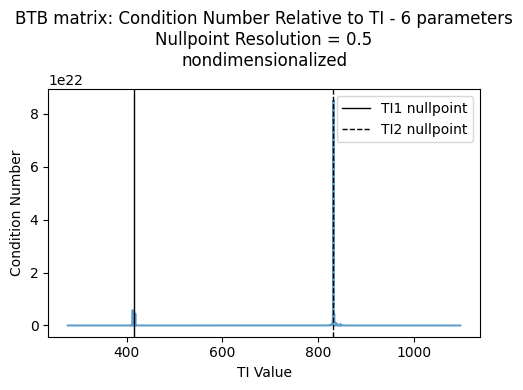

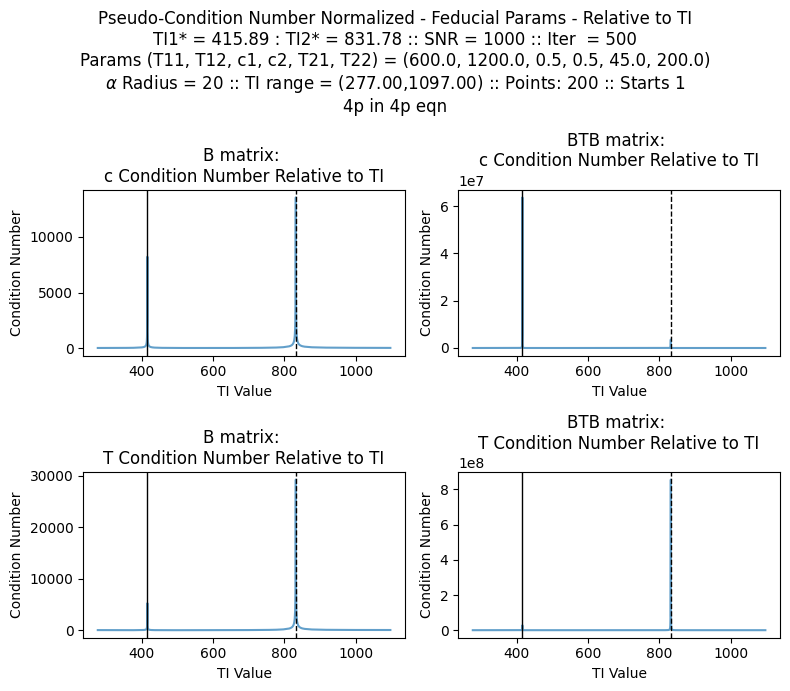

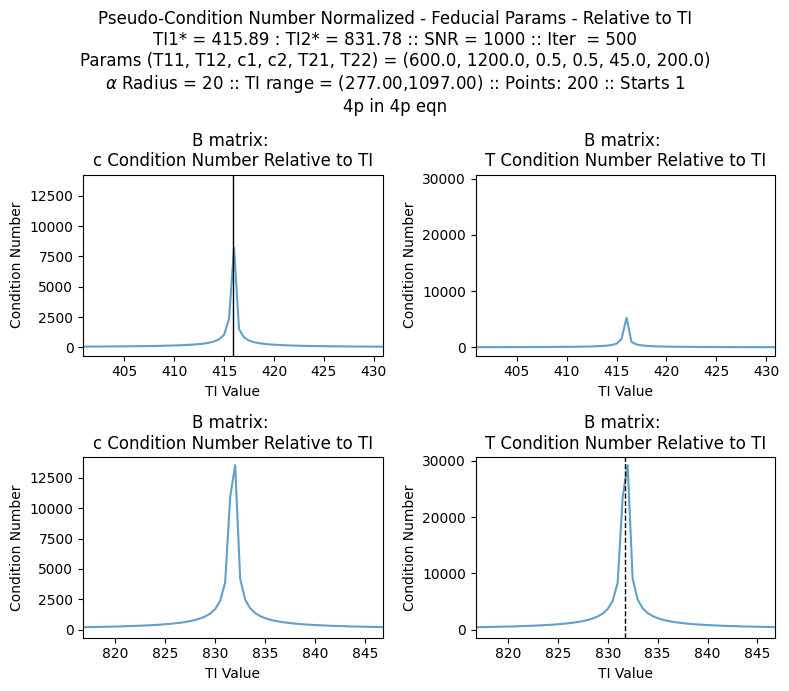

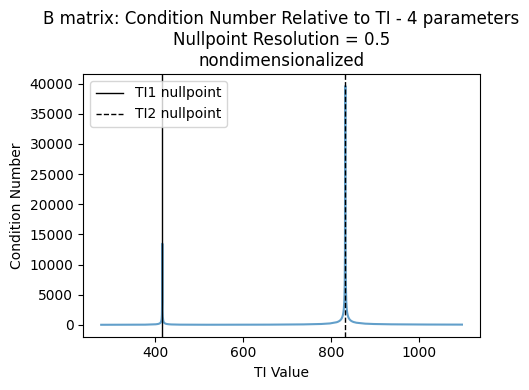

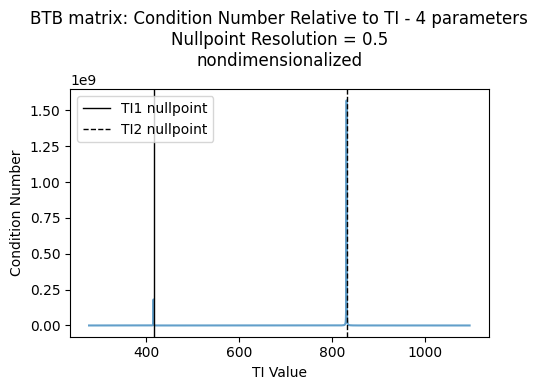

In [21]:
###Conditon Number using different Jacobians

nondimensional_option = True
if nondimensional_option:
    ND_addendum = "\nnondimensionalized"
else:
    ND_addendum = ""

reduced_6p = False
if reduced_6p:
    columns_kept = np.array([0,1,2,3,4,5])
    final_size = columns_kept.shape[0]
    CN_addendum = "\nclip T2s"
else:
    CN_addendum = ""

condition_6p_B = np.zeros((np.size(TI_array),1))
condition_6p_BTB = np.zeros((np.size(TI_array),1))

eigenBig_6p = np.zeros((np.size(TI_array),2))
eigenLil_6p = np.zeros((np.size(TI_array),2))

condition_6p_B_cs = np.zeros((np.size(TI_array),1))
condition_6p_BTB_cs = np.zeros((np.size(TI_array),1))
condition_6p_B_Ts = np.zeros((np.size(TI_array),1))
condition_6p_BTB_Ts = np.zeros((np.size(TI_array),1))

condition_4p_B = np.zeros((np.size(TI_array),1))
condition_4p_BTB = np.zeros((np.size(TI_array),1))

eigenBig_4p = np.zeros((np.size(TI_array),2))
eigenLil_4p = np.zeros((np.size(TI_array),2))

for iTI in range(np.size(TI_array)):

    TI = TI_array[iTI]

    if nondimensional_option:
        B_mat = Jacobian_6p(TE_series, TI, T11, T12, c1, c2, T21, T22, TE_rescale = np.max(TE_series), TI_rescale = np.max(TI_array))
    else:
        B_mat = Jacobian_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)
    if reduced_6p:
        B_mat = B_mat[:,columns_kept]
        assert(B_mat.shape[-1] == final_size)
    _, B_svd, _ = np.linalg.svd(B_mat)
    eigenBig_6p[iTI,0] = B_svd[0]
    eigenLil_6p[iTI,0] = B_svd[-1]
    condition_6p_B[iTI] = np.linalg.cond(B_mat)
    covP = np.dot(B_mat.T,B_mat)
    _, B_svd, _ = np.linalg.svd(covP)
    eigenBig_6p[iTI,1] = B_svd[0]
    eigenLil_6p[iTI,1] = B_svd[-1]
    condition_6p_BTB[iTI] = np.linalg.cond(covP)

    condition_6p_B_cs[iTI] = np.linalg.cond(B_mat[:,2:5])
    condition_6p_B_Ts[iTI] = np.linalg.cond(B_mat[:,[0,1,4,5]])

    condition_6p_BTB_cs[iTI] = np.linalg.cond(np.dot(B_mat[:,2:4].T,B_mat[:,2:4]))
    condition_6p_BTB_Ts[iTI] = np.linalg.cond(np.dot(B_mat[:,[0,1,4,5]].T,B_mat[:,[0,1,4,5]]))

    d1 = d_value(TI,c1,T11)
    d2 = d_value(TI,c2,T12)
    if nondimensional_option:
        B_mat = Jacobian_4p(TE_series, d1, d2, T21, T22, TE_rescale = np.max(TE_series))
    else:
        B_mat = Jacobian_4p(TE_series, d1, d2, T21, T22)
    _, B_svd, _ = np.linalg.svd(B_mat)
    eigenBig_4p[iTI,0] = B_svd[0]
    eigenLil_4p[iTI,0] = B_svd[-1]
    condition_4p_B[iTI] = np.linalg.cond(B_mat)
    covP = np.dot(B_mat.T,B_mat)
    _, B_svd, _ = np.linalg.svd(covP)
    eigenBig_4p[iTI,1] = B_svd[0]
    eigenLil_4p[iTI,1] = B_svd[-1]
    condition_4p_BTB[iTI] = np.linalg.cond(covP)

fig = plt.figure(1, figsize=(5,4), tight_layout=True)
plt.rc('font', size = 10)
plt.plot(TI_array, condition_6p_B, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('B matrix: Condition Number Relative to TI - 6 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum + ND_addendum)
plt.legend()
plt.show()

fig = plt.figure(1, figsize=(5,4), tight_layout=True)
plt.plot(TI_array, condition_6p_BTB, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('BTB matrix: Condition Number Relative to TI - 6 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum + ND_addendum)
plt.legend()
plt.show()

fig, ax = plt.subplots(2,2, figsize=(8,7), tight_layout=True)
fig.suptitle('Pseudo-Condition Number Normalized - Feducial Params - Relative to TI' + details)
ax[0,0].plot(TI_array, condition_6p_B_cs, alpha = 0.7, label = 'B-c')
ax[0,1].plot(TI_array, condition_6p_BTB_cs, alpha = 0.7, label = 'BTB-c')
ax[1,0].plot(TI_array, condition_6p_B_Ts, alpha = 0.7, label = 'B-T')
ax[1,1].plot(TI_array, condition_6p_BTB_Ts, alpha = 0.7, label = 'BTB-T')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0,0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[1,0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
    ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,0].set_xlabel('TI Value')
ax[0,1].set_xlabel('TI Value')
ax[1,0].set_xlabel('TI Value')
ax[1,1].set_xlabel('TI Value')
ax[0,0].set_ylabel('Condition Number')
ax[0,1].set_ylabel('Condition Number')
ax[1,0].set_ylabel('Condition Number')
ax[1,1].set_ylabel('Condition Number')
ax[0,0].set_title('B matrix: \nc Condition Number Relative to TI')
ax[0,1].set_title('BTB matrix: \nc Condition Number Relative to TI')
ax[1,0].set_title('B matrix: \nT Condition Number Relative to TI')
ax[1,1].set_title('BTB matrix: \nT Condition Number Relative to TI')
plt.show()

fig, ax = plt.subplots(2,2, figsize=(8,7), tight_layout=True)
fig.suptitle('Pseudo-Condition Number Normalized - Feducial Params - Relative to TI' + details)
ax[0,0].plot(TI_array, condition_6p_B_cs, alpha = 0.7)
ax[0,1].plot(TI_array, condition_6p_B_Ts, alpha = 0.7)
ax[1,0].plot(TI_array, condition_6p_B_cs, alpha = 0.7)
ax[1,1].plot(TI_array, condition_6p_B_Ts, alpha = 0.7)
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,0].set_xlabel('TI Value')
ax[0,1].set_xlabel('TI Value')
ax[1,0].set_xlabel('TI Value')
ax[1,1].set_xlabel('TI Value')
ax[0,0].set_ylabel('Condition Number')
ax[0,1].set_ylabel('Condition Number')
ax[1,0].set_ylabel('Condition Number')
ax[1,1].set_ylabel('Condition Number')
ax[0,0].set_title('B matrix: \nc Condition Number Relative to TI')
ax[0,1].set_title('B matrix: \nT Condition Number Relative to TI')
ax[1,0].set_title('B matrix: \nc Condition Number Relative to TI')
ax[1,1].set_title('B matrix: \nT Condition Number Relative to TI')
ax[0,0].set_xlim([TI1star-rad, TI1star+rad])
ax[0,1].set_xlim([TI1star-rad, TI1star+rad])
ax[1,0].set_xlim([TI2star-rad, TI2star+rad])
ax[1,1].set_xlim([TI2star-rad, TI2star+rad])
plt.show()

fig= plt.figure(1, figsize=(5,4), tight_layout=True)
plt.plot(TI_array, condition_4p_B, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('B matrix: Condition Number Relative to TI - 4 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + ND_addendum)
plt.legend()
plt.show()

fig = plt.figure(1, figsize=(5,4), tight_layout=True)
plt.plot(TI_array, condition_4p_BTB, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Condition Number')
plt.title('BTB matrix: Condition Number Relative to TI - 4 parameters'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + ND_addendum)
plt.legend()
plt.show()

##### Official CN Figure

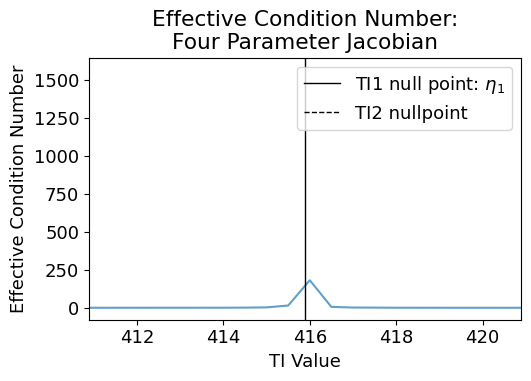

In [22]:
fig = plt.figure(1, figsize=(5.5,4), tight_layout=True)
plt.rc('font', size = 13)
plt.plot(TI_array, condition_4p_BTB*(1/SNR)**2, alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= r'TI1 null point: $\eta_1$', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Effective Condition Number')
plt.title('Effective Condition Number:' + '\nFour Parameter Jacobian')
plt.xlim((TI1star-5,TI1star+5))
plt.legend()
plt.show()

##### Singular Value Plots

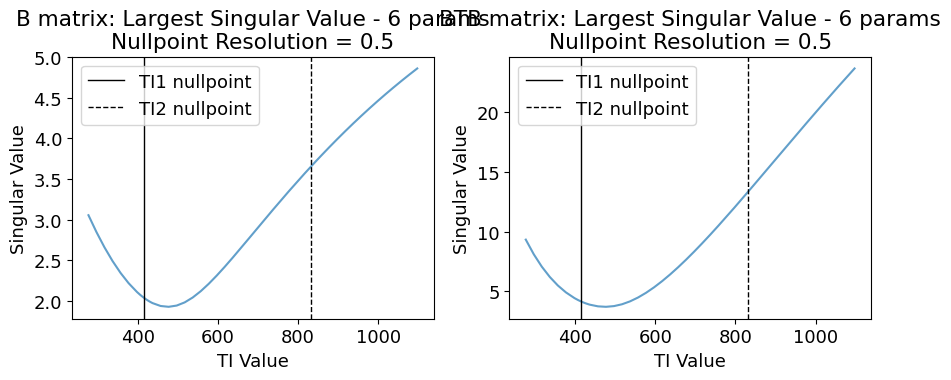

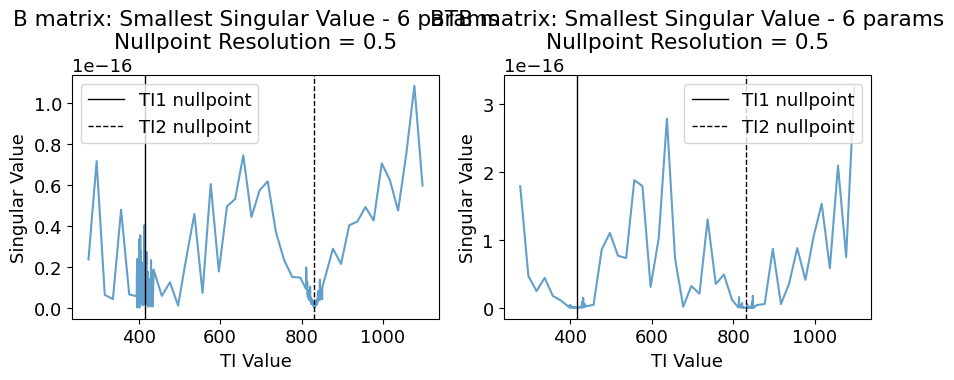

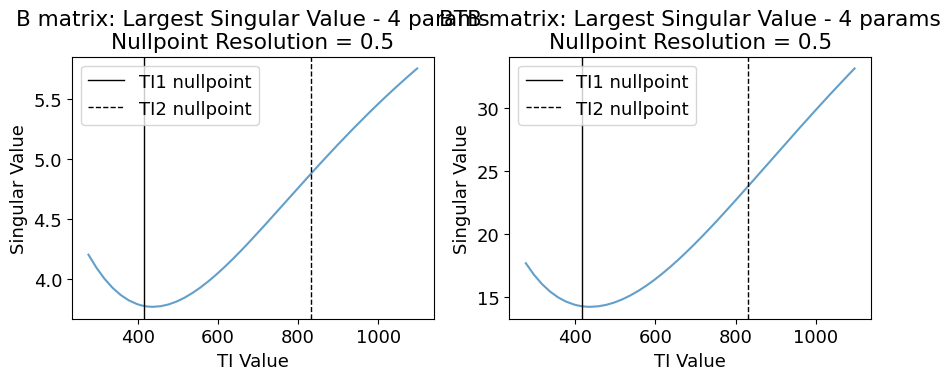

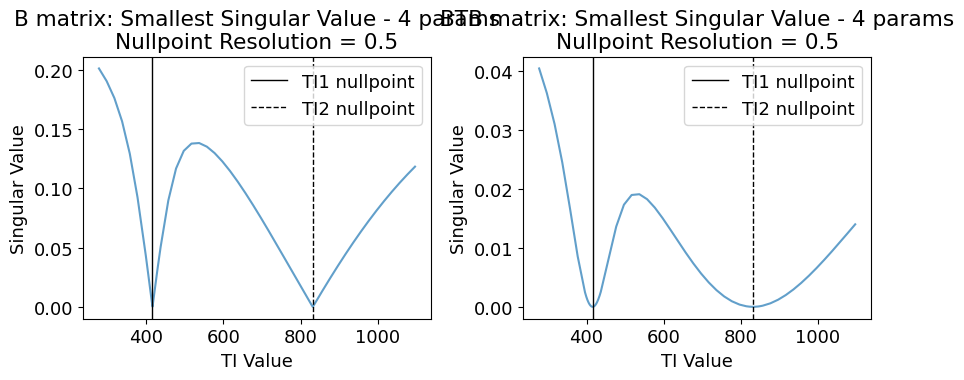

In [23]:
fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenBig_6p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Largest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[0].legend()

ax[1].plot(TI_array, eigenBig_6p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Largest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[1].legend()

fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenLil_6p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Smallest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[0].legend()

ax[1].plot(TI_array, eigenLil_6p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Smallest Singular Value - 6 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution) + CN_addendum)
ax[1].legend()

fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenBig_4p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Largest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[0].legend()

ax[1].plot(TI_array, eigenBig_4p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Largest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[1].legend()

fig, ax = plt.subplots(1,2, figsize=(9,4), tight_layout=True)
ax[0].plot(TI_array, eigenLil_4p[:,0], alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('Singular Value')
ax[0].set_title('B matrix: Smallest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[0].legend()

ax[1].plot(TI_array, eigenLil_4p[:,1], alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('Singular Value')
ax[1].set_title('BTB matrix: Smallest Singular Value - 4 params'
            + '\nNullpoint Resolution = {:.1f}'.format(nullResolution))
ax[1].legend()

### Residual Sum of Squares Plot

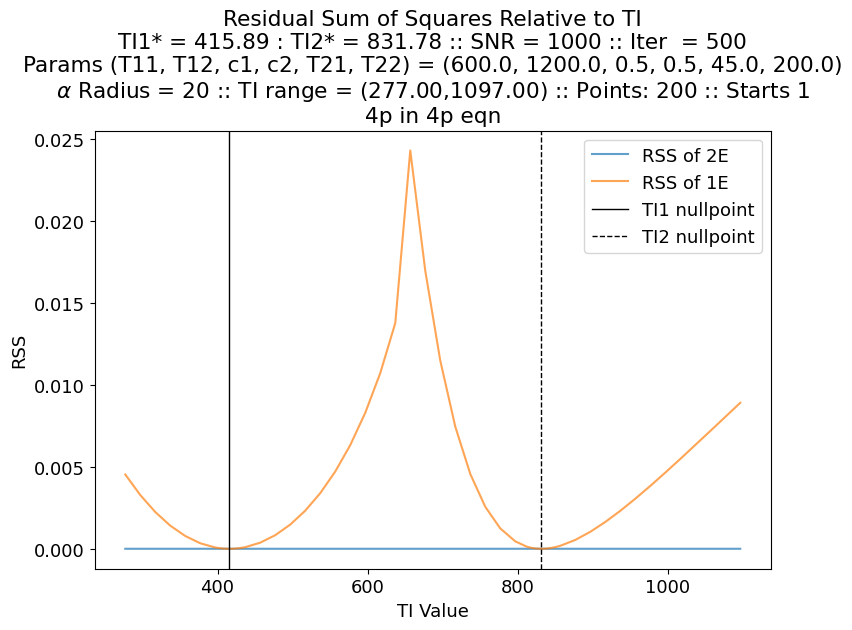

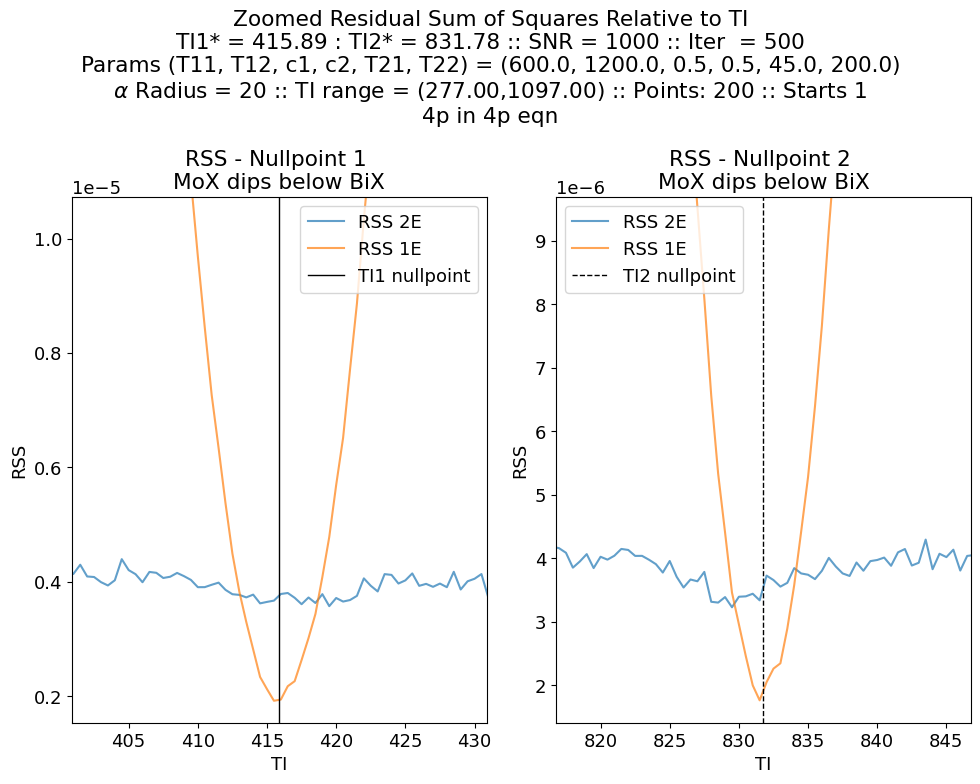

In [24]:
RSS_avg_2E = np.mean(RSS_Store_2E,axis = 1)
RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg_2E, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10,8), tight_layout=True)
fig.suptitle('Zoomed Residual Sum of Squares Relative to TI' + details)

minVal_1E = min(RSS_avg_1E[0: np.size(RSS_avg_1E)//2])
minVal_2E = min(RSS_avg_2E[0: np.size(RSS_avg_2E)//2])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])
ax[0].plot(TI_array, RSS_avg_2E, label = 'RSS 2E', alpha = 0.7)
ax[0].plot(TI_array, RSS_avg_1E, label = 'RSS 1E', alpha = 0.7)
if minVal_1E < minVal_2E:
    ax[0].set_title('RSS - Nullpoint 1 \nMoX dips below BiX')
else:
    ax[0].set_title('RSS - Nullpoint 1 \nMoX does NOT dip below BiX')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('RSS')
ax[0].set_ylim([0.8*min_meas,3*max_meas])
ax[0].set_xlim([TI1star-rad, TI1star+rad])
ax[0].legend()

minVal_1E = min(RSS_avg_1E[np.size(RSS_avg_1E)//2:])
minVal_2E = min(RSS_avg_2E[np.size(RSS_avg_2E)//2:])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])

ax[1].plot(TI_array, RSS_avg_2E, label = 'RSS 2E', alpha = 0.7)
ax[1].plot(TI_array, RSS_avg_1E, label = 'RSS 1E', alpha = 0.7)
if minVal_1E < minVal_2E:
    ax[1].set_title('RSS - Nullpoint 2 \nMoX dips below BiX')
else:
    ax[1].set_title('RSS - Nullpoint 2 \nMoX does NOT dip below BiX')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('RSS')
ax[1].set_ylim([0.8*min_meas,3*max_meas])
ax[1].set_xlim([TI2star-rad, TI2star+rad])
ax[1].legend()

### Residual Sum of Squares Plot - Noised

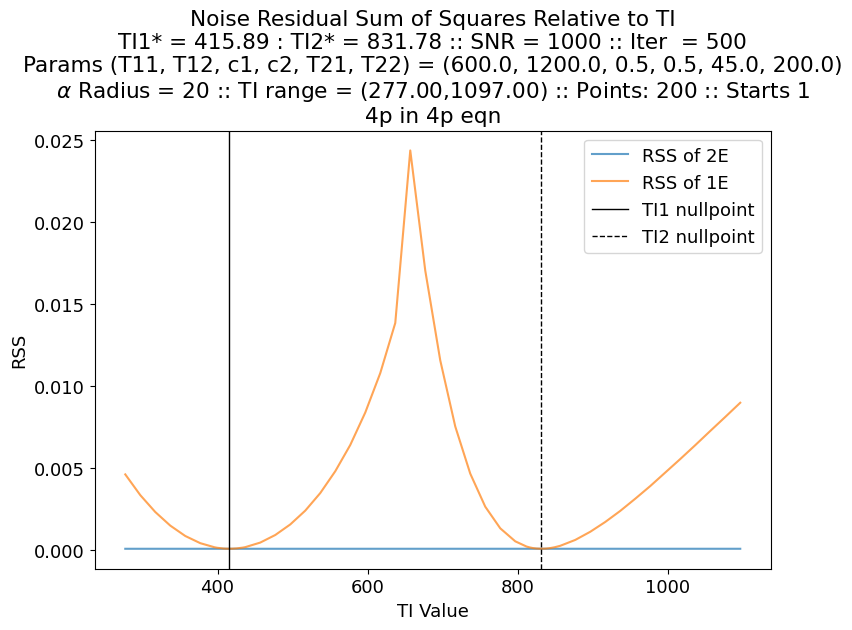

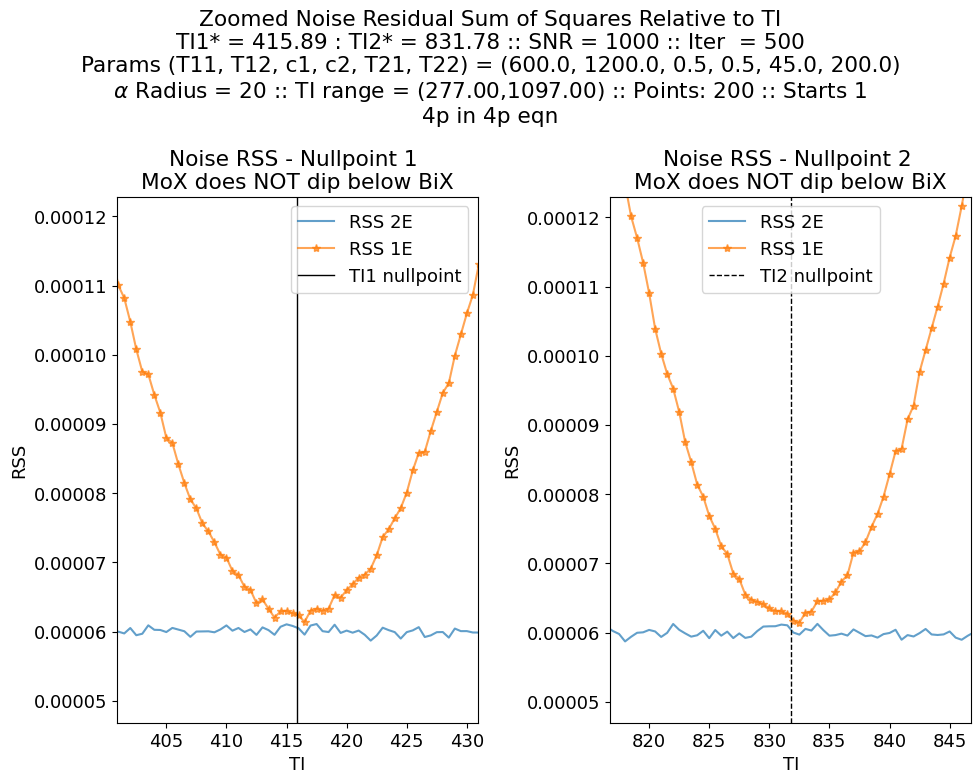

In [25]:
nRSS_avg_2E = np.mean(RSS_Noise_Store_2E,axis = 1)
nRSS_avg_1E = np.mean(RSS_Noise_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,nRSS_avg_2E, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,nRSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Noise Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,2,figsize=(10,8), tight_layout=True)
fig.suptitle('Zoomed Noise Residual Sum of Squares Relative to TI' + details)

minVal_1E = min(nRSS_avg_1E[0: np.size(nRSS_avg_1E)//2])
minVal_2E = min(nRSS_avg_2E[0: np.size(nRSS_avg_2E)//2])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])
ax[0].plot(TI_array, nRSS_avg_2E, label = 'RSS 2E', alpha = 0.7)
ax[0].plot(TI_array, nRSS_avg_1E, label = 'RSS 1E', alpha = 0.7, marker = '*')
if minVal_1E < minVal_2E:
    ax[0].set_title('Noise RSS - Nullpoint 1 \nMoX dips below BiX')
else:
    ax[0].set_title('Noise RSS - Nullpoint 1 \nMoX does NOT dip below BiX')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('RSS')
ax[0].set_ylim([0.8*min_meas,2*max_meas])
ax[0].set_xlim([TI1star-rad, TI1star+rad])
ax[0].legend()

minVal_1E = min(nRSS_avg_1E[np.size(nRSS_avg_1E)//2:])
minVal_2E = min(nRSS_avg_2E[np.size(nRSS_avg_2E)//2:])
min_meas = min([minVal_1E,minVal_2E])
max_meas = max([minVal_1E,minVal_2E])

ax[1].plot(TI_array, nRSS_avg_2E, label = 'RSS 2E', alpha = 0.7)
ax[1].plot(TI_array, nRSS_avg_1E, label = 'RSS 1E', alpha = 0.7, marker = '*')
if minVal_1E < minVal_2E:
    ax[1].set_title('Noise RSS - Nullpoint 2 \nMoX dips below BiX')
else:
    ax[1].set_title('Noise RSS - Nullpoint 2 \nMoX does NOT dip below BiX')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('RSS')
ax[1].set_ylim([0.8*min_meas,2*max_meas])
ax[1].set_xlim([TI2star-rad, TI2star+rad])
ax[1].legend()

### Residual Sum of Squares - Region

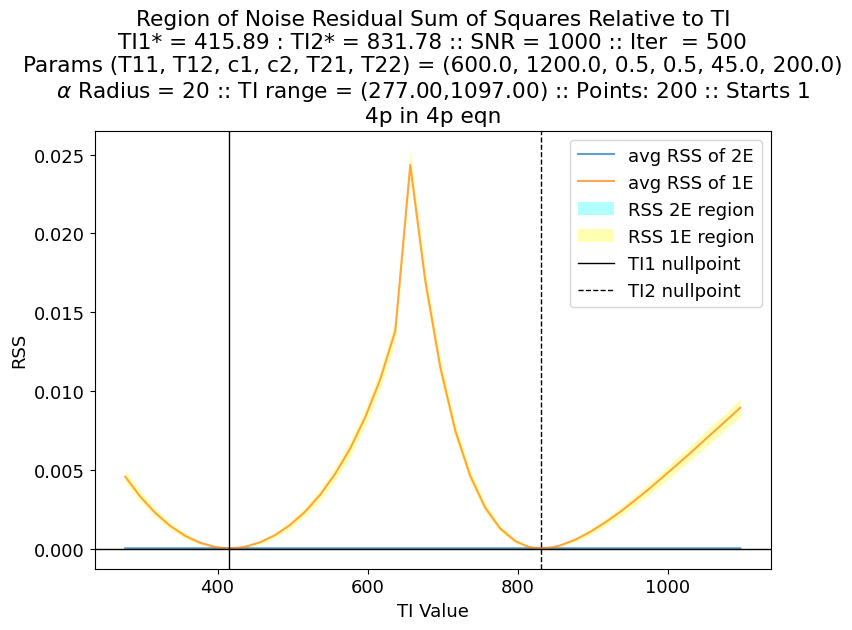

16 incorrect RSS pairings out of 100000 noisy signals
RSS violations at TI = 413.0 :: 1 violations
RSS violations at TI = 415.0 :: 1 violations
RSS violations at TI = 415.5 :: 1 violations
RSS violations at TI = 416.0 :: 1 violations
RSS violations at TI = 416.5 :: 1 violations
RSS violations at TI = 417.5 :: 2 violations
RSS violations at TI = 832.0 :: 7 violations
RSS violations at TI = 832.5 :: 2 violations


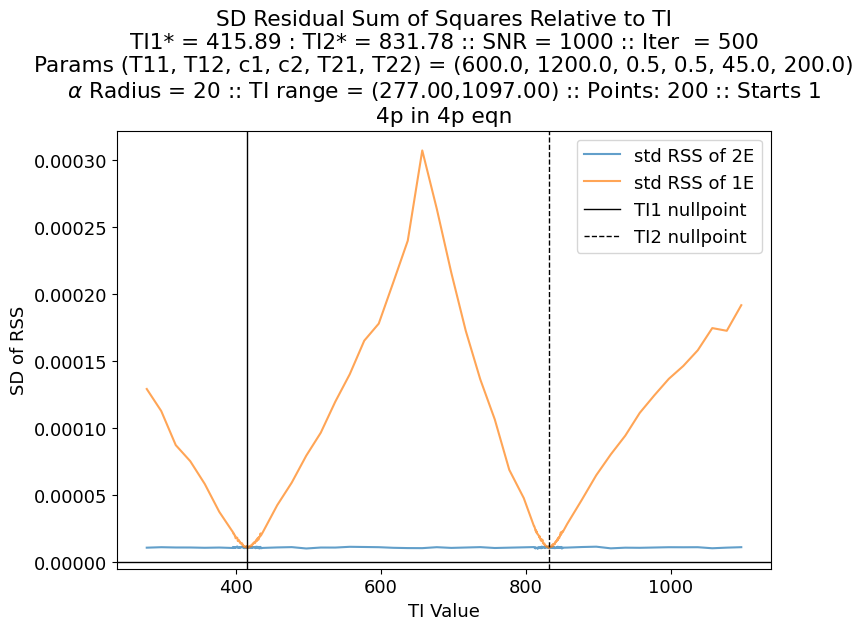

In [26]:
nRSS_sd_2E = np.std(RSS_Noise_Store_2E,axis = 1)
nRSS_sd_1E = np.std(RSS_Noise_Store_1E,axis = 1)

nRSS_ub_2E = nRSS_avg_2E + 3*nRSS_sd_2E
nRSS_lb_2E = nRSS_avg_2E - 3*nRSS_sd_2E
nRSS_ub_1E = nRSS_avg_1E + 3*nRSS_sd_1E
nRSS_lb_1E = nRSS_avg_1E - 3*nRSS_sd_1E

fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,nRSS_avg_2E, label = 'avg RSS of 2E', alpha = 0.7)
plt.plot(TI_array,nRSS_avg_1E, label = 'avg RSS of 1E', alpha = 0.7)
plt.fill_between(TI_array,nRSS_lb_2E, nRSS_ub_2E, color = 'cyan', alpha = 0.3, lw=0, label = 'RSS 2E region')
plt.fill_between(TI_array,nRSS_lb_1E, nRSS_ub_1E, color = 'yellow', alpha = 0.3, lw=0, label = 'RSS 1E region')
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axhline(y=0, linewidth=1, color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Region of Noise Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

RSS_check = RSS_Noise_Store_2E > RSS_Noise_Store_1E
print(f"{np.sum(RSS_check)} incorrect RSS pairings out of {np.size(RSS_check)} noisy signals")
indices = np.nonzero(RSS_check)
indices_x = indices[0]
indices_y = indices[1]

TI_indices, TI_counts = np.unique(indices_x, return_counts = True)

for i in range(TI_indices.shape[0]):
    print(f"RSS violations at TI = {TI_array[TI_indices[i]]} :: {TI_counts[i]} violations")

fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,nRSS_sd_2E, label = 'std RSS of 2E', alpha = 0.7)
plt.plot(TI_array,nRSS_sd_1E, label = 'std RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axhline(y=0, linewidth=1, color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('SD of RSS')
plt.title('SD Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### Residual Sum of Squares Theoretical

In [27]:
noiseless_ref = True   #Solve a bunch of soln with no noise added

TI1_subset_index = np.where([(x in TI1_array) for x in TI_array])

nRSS_avg_1E_TI1subset = nRSS_avg_1E[TI1_subset_index]
nRSS_avg_2E_TI1subset = nRSS_avg_2E[TI1_subset_index]

if noiseless_ref:
    RSS_noiseless_1E_TI1subset = np.zeros(TI1_array.shape)
    RSS_noiseless_2E_TI1subset = np.zeros(TI1_array.shape)


TE_diff = np.unique(np.diff(TE_series))
assert(TE_diff.shape[0] == 1)

RSS_ther_error = 0
R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI1subset = np.zeros(TI1_array.shape)

starts_here = 15

for k in trange(np.size(TI1_array)):

    TI = TI1_array[k]

    RSS_theoretical_1E_TI1subset[k] = R0_coeff_TI1*(TI - TI1star)**2

    if noiseless_ref:
        true_d1 = d_value(TI, c1, T11)
        true_d2 = d_value(TI, c2, T12)

        realParams_4p = np.array([true_d1, true_d2, T21, T22])

        realParams = np.array([c1,c2,T21,T22])

        trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
        trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

        assert(np.allclose(trueDat,trueDat_4p))

        RSS_best = np.inf
        for start in range(starts_here):
            #Running all the biexponential fits
            try:
                ub = (1,1,T2_bound,T2_bound)
                lb = (-1,-1,0,0)

                init_p = np.array(lb) + (np.array(ub)- np.array(lb))*np.random.uniform(0,1,np.size(lb))
                init_p = list(init_p)

                popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, trueDat_4p, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                popt_2E = check_param_order(popt_2E)
                est_Sig_2E = S_biX_4p(TE_series, *popt_2E)

                RSS_hol = np.sum((est_Sig_2E - trueDat_4p)**2)

                if RSS_hol < RSS_best:
                    RSS_best = RSS_hol

            except Exception as e:
                print("Biexponential")
                print(e)
                continue

        RSS_noiseless_2E_TI1subset[k] = RSS_best

        try:
            init_p = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, trueDat_4p, p0 = init_p, maxfev = 1500)
            est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
            RSS_noiseless_1E_TI1subset[k] = np.sum((est_Sig_1E - trueDat_4p)**2)

        except Exception as e:
            print(e)
            RSS_ther_error += 1
            continue


100%|██████████| 81/81 [01:22<00:00,  1.02s/it]


In [28]:
if bothTI:
    TI2_subset_index = np.where([(x in TI2_array) for x in TI_array])

    nRSS_avg_1E_TI2subset = nRSS_avg_1E[TI2_subset_index]
    nRSS_avg_2E_TI2subset = nRSS_avg_2E[TI2_subset_index]

    if noiseless_ref:
        RSS_noiseless_1E_TI2subset = np.zeros(TI2_array.shape)
        RSS_noiseless_2E_TI2subset = np.zeros(TI2_array.shape)

    RSS_ther_error = 0
    R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
    RSS_theoretical_1E_TI2subset = np.zeros(TI2_array.shape)

    starts_here = 15

    for k in trange(np.size(TI2_array)):

        TI = TI2_array[k]

        RSS_theoretical_1E_TI2subset[k] = R0_coeff_TI2*(TI - TI2star)**2

        if noiseless_ref:
            true_d1 = d_value(TI, c1, T11)
            true_d2 = d_value(TI, c2, T12)

            realParams_4p = np.array([true_d1, true_d2, T21, T22])

            realParams = np.array([c1,c2,T21,T22])

            trueDat_4p = S_biX_4p(TE_series, *realParams_4p)
            trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

            assert(np.allclose(trueDat,trueDat_4p))

            RSS_best = np.inf
            for start in range(starts_here):
                #Running all the biexponential fits
                try:
                    ub = (1,1,T2_bound,T2_bound)
                    lb = (-1,-1,0,0)

                    init_p = np.array(lb) + (np.array(ub)- np.array(lb))*np.random.uniform(0,1,np.size(lb))
                    init_p = list(init_p)

                    popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, trueDat_4p, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                    popt_2E = check_param_order(popt_2E)
                    est_Sig_2E = S_biX_4p(TE_series, *popt_2E)

                    RSS_hol = np.sum((est_Sig_2E - trueDat_4p)**2)

                    if RSS_hol < RSS_best:
                        RSS_best = RSS_hol

                except Exception as e:
                    print("Biexponential")
                    print(e)
                    continue

            RSS_noiseless_2E_TI2subset[k] = RSS_best

            try:
                init_p = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

                popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, trueDat_4p, p0 = init_p, maxfev = 1500)
                est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
                RSS_noiseless_1E_TI2subset[k] = np.sum((est_Sig_1E - trueDat_4p)**2)

            except Exception as e:
                print(e)
                RSS_ther_error += 1
                continue


 15%|█▍        | 12/81 [00:04<00:29,  2.35it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_5004\323040649.py:14: RuntimeWarning: overflow encountered in exp
  return d*np.exp(-TE/T2)
100%|██████████| 81/81 [00:22<00:00,  3.55it/s]


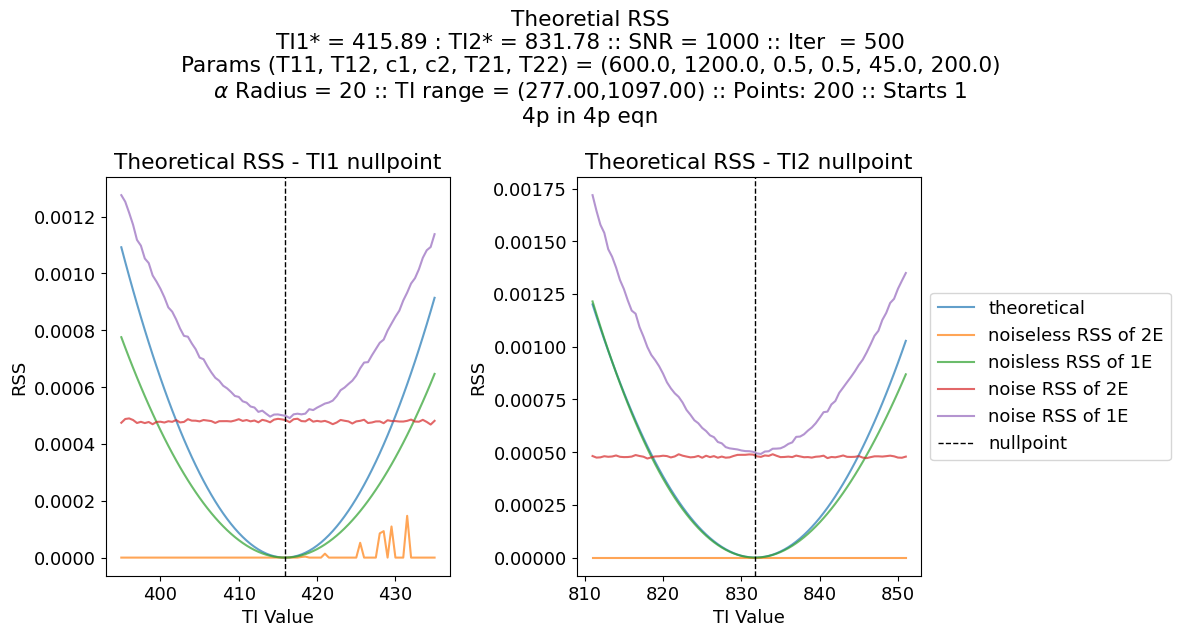

In [29]:
if bothTI:
    fig, ax = plt.subplots(1,2, figsize=(12,6.5), tight_layout=True)
else:
    fig, ax = plt.subplots(1,1, figsize=(10,6.5), tight_layout=True)
fig.suptitle('Theoretial RSS' + details)
ax[0].plot(TI1_array, RSS_theoretical_1E_TI1subset, label = 'theoretical', alpha = 0.7)
if noiseless_ref:
    ax[0].plot(TI1_array, RSS_noiseless_2E_TI1subset*TE_diff, label = 'pure RSS of 2E', alpha = 0.7)
    ax[0].plot(TI1_array, RSS_noiseless_1E_TI1subset*TE_diff, label = 'pure RSS of 1E', alpha = 0.7)
ax[0].plot(TI_array[TI1_subset_index], nRSS_avg_2E_TI1subset*TE_diff, label = 'noise RSS of 2E', alpha = 0.7)
ax[0].plot(TI_array[TI1_subset_index], nRSS_avg_1E_TI1subset*TE_diff, label = 'noise RSS of 1E', alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('Theoretical RSS - TI1 nullpoint')
# ax[0].legend()
# ax[0].set_ylim([0,0.0001])
# ax[0].set_xlim([TI1star-5,TI1star+5])
if bothTI:
    ax[1].plot(TI2_array, RSS_theoretical_1E_TI2subset, label = 'theoretical', alpha = 0.7)
    if noiseless_ref:
        ax[1].plot(TI2_array, RSS_noiseless_2E_TI2subset*TE_diff, label = 'noiseless RSS of 2E', alpha = 0.7)
        ax[1].plot(TI2_array, RSS_noiseless_1E_TI2subset*TE_diff, label = 'noisless RSS of 1E', alpha = 0.7)
    ax[1].plot(TI_array[TI2_subset_index], nRSS_avg_2E_TI2subset*TE_diff, label = 'noise RSS of 2E', alpha = 0.7)
    ax[1].plot(TI_array[TI2_subset_index], nRSS_avg_1E_TI2subset*TE_diff, label = 'noise RSS of 1E', alpha = 0.7)
    ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
    ax[1].set_xlabel('TI Value')
    ax[1].set_ylabel('RSS')
    ax[1].set_title('Theoretical RSS - TI2 nullpoint')
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # ax[1].set_ylim((0,np.max(RSS_theoretical_1E_TI2subset)))
plt.show()

In [30]:
SNR_array = [750, 1000, 3000, 5000, 10000]
SNR_RSS_array_T1 = np.zeros((TI1_array.shape[0], np.size(SNR_array)))
SNR_RSS_array_T2 = np.zeros((TI2_array.shape[0], np.size(SNR_array)))

repetitions = 100

TE_diff = np.unique(np.diff(TE_series))
assert(TE_diff.shape[0] == 1)

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI1subset = np.zeros(TI1_array.shape)

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI2subset = np.zeros(TI2_array.shape)

for k in trange(np.size(TI1_array)):

    TI1 = TI1_array[k]
    RSS_theoretical_1E_TI1subset[k] = R0_coeff_TI1*(TI1 - TI1star)**2

    TI2 = TI2_array[k]
    RSS_theoretical_1E_TI2subset[k] = R0_coeff_TI2*(TI2 - TI2star)**2

    
    true_d1_T1 = d_value(TI1, c1, T11)
    true_d2_T1 = d_value(TI1, c2, T12)

    true_d1_T2 = d_value(TI2, c1, T11)
    true_d2_T2 = d_value(TI2, c2, T12)

    trueDat_T1 = S_biX_6p(TE_series, TI1, T11, T12, c1, c2, T21, T22)
    trueDat_T2 = S_biX_6p(TE_series, TI2, T11, T12, c1, c2, T21, T22)

    for iSNR in range(np.size(SNR_array)):
        
        repMat_T1 = []
        repMat_T2 = []
        for rep in range(repetitions):

            noiseDat_T1 = add_noise(trueDat_T1, SNR_array[iSNR])
            noiseDat_T2 = add_noise(trueDat_T2, SNR_array[iSNR])

            try:
                init_p = ((true_d1_T1 + true_d2_T1)/2 , (T21 + T22)/2)

                popt_1E_T1, _ = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat_T1, p0 = init_p, maxfev = 1500)
                est_Sig_1E_T1 = S_moX_2p(TE_series, *popt_1E_T1)

                repMat_T1.append( np.sum((est_Sig_1E_T1 - noiseDat_T1)**2))

                init_p = ((true_d1_T2 + true_d2_T2)/2 , (T21 + T22)/2)

                popt_1E_T2, _ = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat_T2, p0 = init_p, maxfev = 1500)
                est_Sig_1E_T2 = S_moX_2p(TE_series, *popt_1E_T2)

                repMat_T2.append(np.sum((est_Sig_1E_T2 - noiseDat_T2)**2))
                
        
            except Exception as e:
                print(e)
                RSS_ther_error += 1
                continue

        SNR_RSS_array_T1[k, iSNR] = np.mean(repMat_T1)
        SNR_RSS_array_T2[k, iSNR] = np.mean(repMat_T2)

  0%|          | 0/81 [00:00<?, ?it/s]C:\Users\griff\AppData\Local\Temp\ipykernel_5004\323040649.py:14: RuntimeWarning: overflow encountered in exp
  return d*np.exp(-TE/T2)
100%|██████████| 81/81 [00:35<00:00,  2.26it/s]


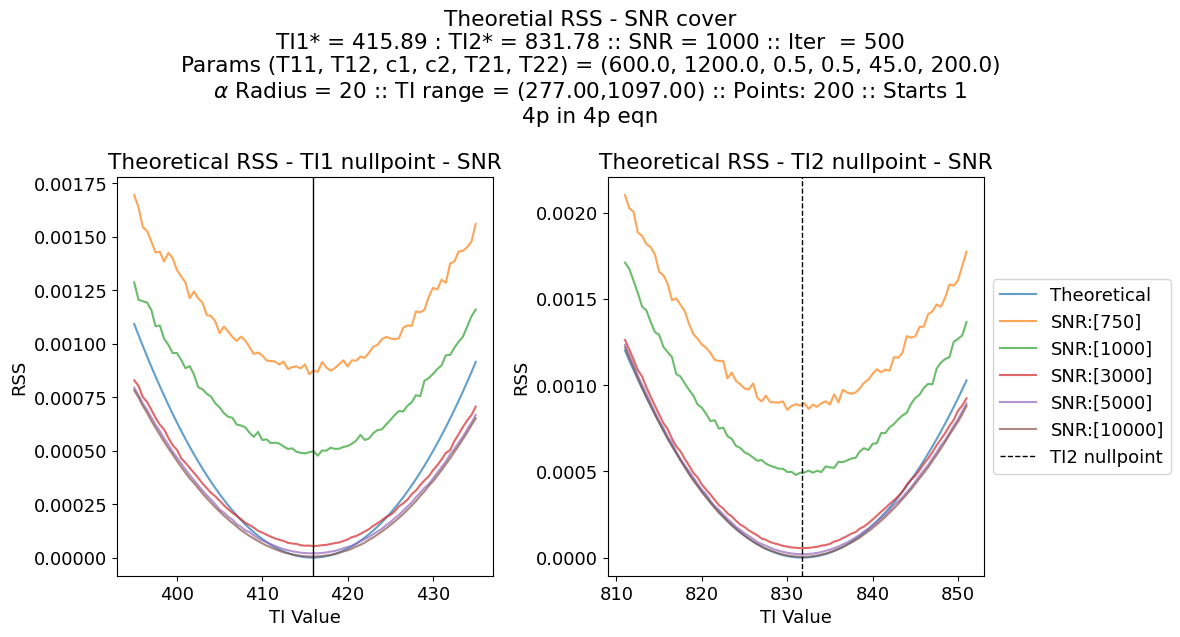

In [31]:
fig, ax = plt.subplots(1,2, figsize=(12,6.5), tight_layout=True)
fig.suptitle('Theoretial RSS - SNR cover' + details)
ax[0].plot(TI1_array, RSS_theoretical_1E_TI1subset, label = 'Theoretical', alpha = 0.7)
for iPlot in range(np.size(SNR_array)):
    ax[0].plot(TI1_array, SNR_RSS_array_T1[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('Theoretical RSS - TI1 nullpoint - SNR')
# ax[0].legend()


ax[1].plot(TI2_array, RSS_theoretical_1E_TI2subset, label = 'Theoretical', alpha = 0.7)
for iPlot in range(np.size(SNR_array)):
    ax[1].plot(TI2_array, SNR_RSS_array_T2[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7)
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('Theoretical RSS - TI2 nullpoint - SNR')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##### Determine Offset Measure

In [32]:
SNR_array = np.array([750, 1000, 1500, 3000, 5000, 10000])
SNR_RSS_array_T1 = np.zeros((TI1_array.shape[0], np.size(SNR_array)))
SNR_RSS_array_T2 = np.zeros((TI2_array.shape[0], np.size(SNR_array)))

RSS_levels = np.size(TE_series)*(1/SNR_array)**2

RSS_levels_colors = _get_colors(np.size(SNR_array))

repetitions = 50

TE_diff = np.unique(np.diff(TE_series))
assert(TE_diff.shape[0] == 1)

R0_coeff_TI1 = (c1**2 * T21 *(T21 - T22)**4)/(2*T11**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI1subset = np.zeros(TI1_array.shape)

R0_coeff_TI2 = (c2**2 * T22 *(T21 - T22)**4)/(2*T12**2 * (T21 + T22)**4)
RSS_theoretical_1E_TI2subset = np.zeros(TI2_array.shape)

for k in trange(np.size(TI1_array)):

    TI1 = TI1_array[k]
    RSS_theoretical_1E_TI1subset[k] = R0_coeff_TI1*(TI1 - TI1star)**2

    TI2 = TI2_array[k]
    RSS_theoretical_1E_TI2subset[k] = R0_coeff_TI2*(TI2 - TI2star)**2

    
    true_d1_T1 = d_value(TI1, c1, T11)
    true_d2_T1 = d_value(TI1, c2, T12)

    realParams_4p_T1 = np.array([true_d1_T1, true_d2_T2, T21, T22])

    true_d1_T2 = d_value(TI2, c1, T11)
    true_d2_T2 = d_value(TI2, c2, T12)

    realParams_4p_T2 = np.array([true_d1_T1, true_d2_T2, T21, T22])

    trueDat_T1 = S_biX_6p(TE_series, TI1, T11, T12, c1, c2, T21, T22)
    trueDat_T2 = S_biX_6p(TE_series, TI2, T11, T12, c1, c2, T21, T22)

    for iSNR in range(np.size(SNR_array)):
        
        repMat_T1 = []
        repMat_T2 = []
        for rep in range(repetitions):

            noiseDat_T1 = add_noise(trueDat_T1, SNR_array[iSNR])
            noiseDat_T2 = add_noise(trueDat_T2, SNR_array[iSNR])

            try:
                init_p = realParams_4p_T1
                    
                popt_2E_T1, _ = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat_T1, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                popt_2E_T1 = check_param_order(popt_2E_T1)
                est_Sig_2E_T1 = S_biX_4p(TE_series, *popt_2E_T1)

                repMat_T1.append( np.sum((est_Sig_2E_T1 - noiseDat_T1)**2))

                init_p = realParams_4p_T2

                popt_2E_T2, _ = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat_T2, p0 = init_p, bounds = [lb,ub], method = 'trf', maxfev = 1500)
                popt_2E_T2 = check_param_order(popt_2E_T2)
                est_Sig_2E_T2 = S_biX_4p(TE_series, *popt_2E_T2)

                repMat_T2.append( np.sum((est_Sig_2E_T2 - noiseDat_T2)**2))
                
        
            except Exception as e:
                print(e)
                RSS_ther_error += 1
                continue

        SNR_RSS_array_T1[k, iSNR] = np.mean(repMat_T1)
        SNR_RSS_array_T2[k, iSNR] = np.mean(repMat_T2)

100%|██████████| 81/81 [23:12<00:00, 17.19s/it]


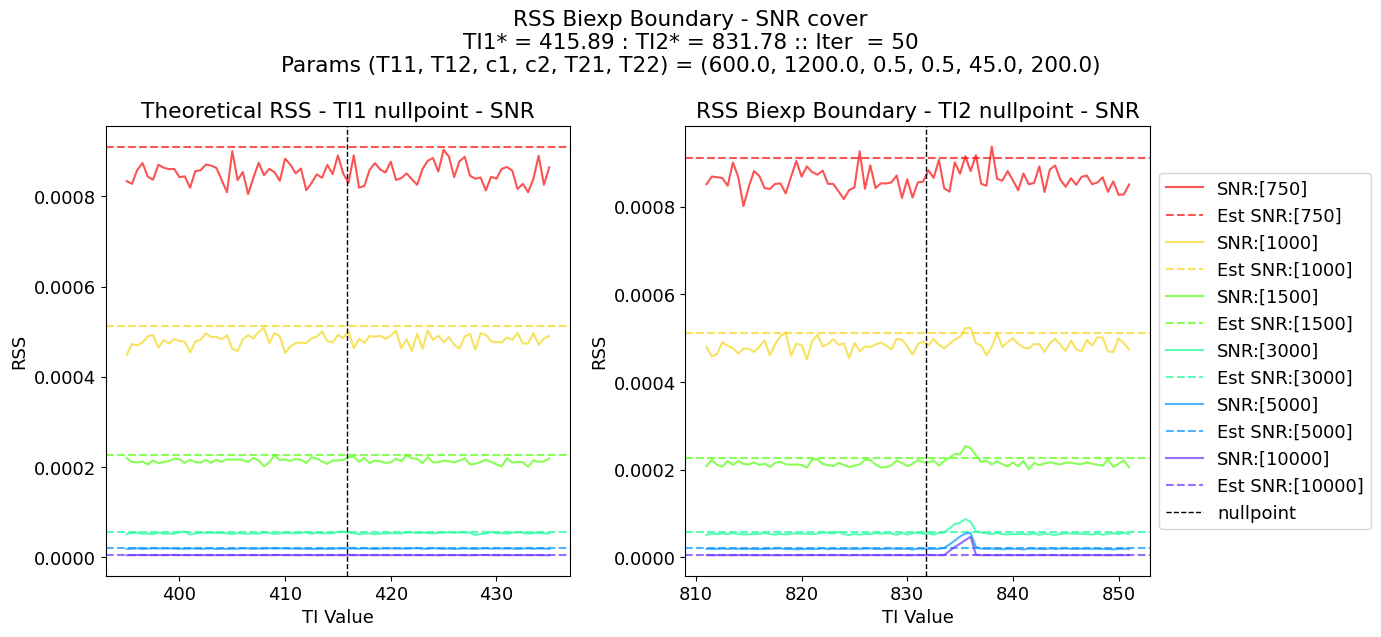

In [33]:
RSS_levels_colors = _get_colors(7)
details_RSS = str('\nTI1* = ' + str(round(TI1star,2)) + ' : TI2* = ' + str(round(TI2star,2)) + " :: Iter  = " + str(repetitions) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')

fig, ax = plt.subplots(1,2, figsize=(14,6.5), tight_layout=True)
fig.suptitle('RSS Biexp Boundary - SNR cover' + details_RSS)
for iPlot in range(np.size(SNR_array)):
    ax[0].plot(TI1_array, SNR_RSS_array_T1[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    ax[0].axhline(y = RSS_levels[iPlot]*TE_diff, label = f'Est SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('RSS')
ax[0].set_title('Theoretical RSS - TI1 nullpoint - SNR')
# ax[0].legend()

for iPlot in range(np.size(SNR_array)):
    ax[1].plot(TI2_array, SNR_RSS_array_T2[:,iPlot]*TE_diff, label = f'SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot])
    ax[1].axhline(y = RSS_levels[iPlot]*TE_diff, label = f'Est SNR:[{SNR_array[iPlot]}]', alpha = 0.7, color = RSS_levels_colors[iPlot], ls = '--')
ax[1].axvline(x=TI2star, linewidth=1, label= 'nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('RSS')
ax[1].set_title('RSS Biexp Boundary - TI2 nullpoint - SNR')
box = ax[1].get_position()
# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

##### Additional Theoretical Curves

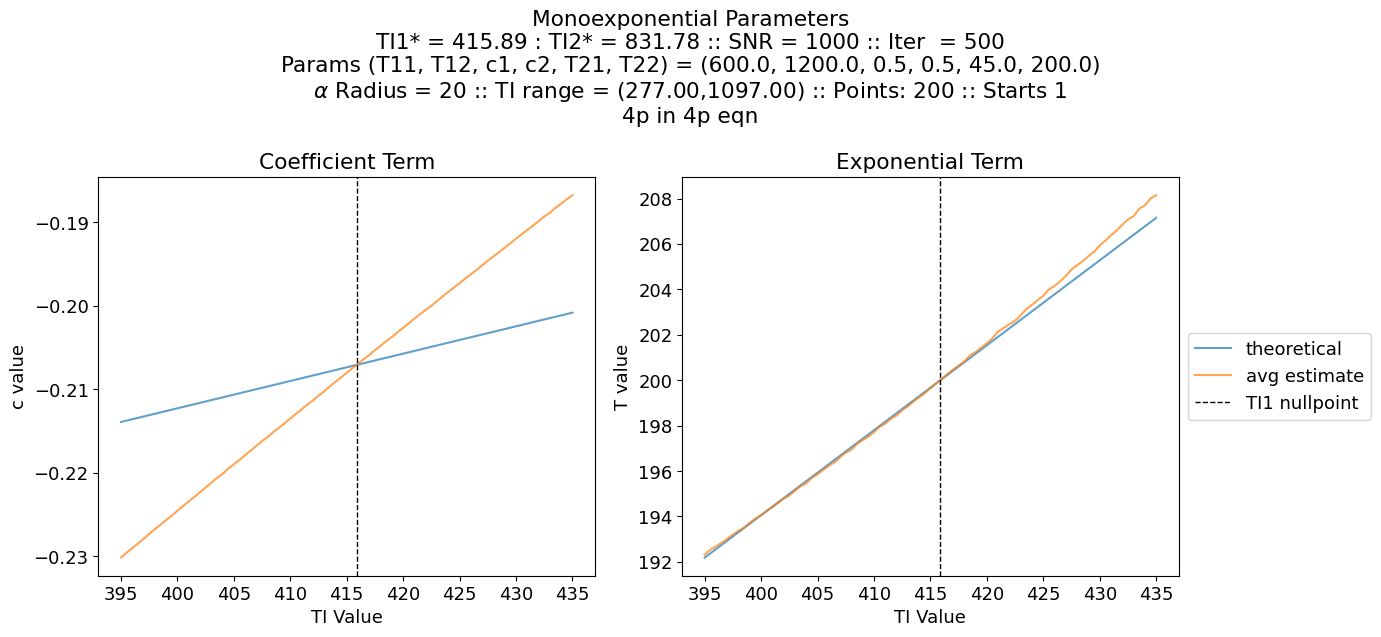

In [34]:
fstar = c2 * (1 - 2**(1 - T11/T12))
Tstar = T22

TI1_subset_index = np.where([(x in TI1_array) for x in TI_array])

avg_1E_params = np.mean(paramStore_1E, axis = 1)
avg_1E_c = avg_1E_params[:,0]
avg_1E_T = avg_1E_params[:,1]
avg_1E_c = avg_1E_c[TI1_subset_index]
avg_1E_T = avg_1E_T[TI1_subset_index]


f_array = fstar + (4*c1*T21*T22/(T11*(T21+T22)**2) + fstar/T12) * (TI1_array - TI1star)
T_array = Tstar + (4*c1*T21*T22*(T21-T22)/(fstar*T11*(T21+T22)**2)) * (TI1_array - TI1star)

fig, ax = plt.subplots(1,2, figsize=(14,6.5), tight_layout=True)
fig.suptitle('Monoexponential Parameters' + details)
ax[0].plot(TI1_array, f_array, label = 'theoretical', alpha = 0.7)
ax[0].plot(TI1_array, avg_1E_c, label = 'avg estimate', alpha = 0.7)
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI Value')
ax[0].set_ylabel('c value')
ax[0].set_title('Coefficient Term')
# ax[0].legend()

ax[1].plot(TI1_array, T_array, label = 'theoretical', alpha = 0.7)
ax[1].plot(TI1_array, avg_1E_T, label = 'avg estimate', alpha = 0.7)
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI Value')
ax[1].set_ylabel('T value')
ax[1].set_title('Exponential Term')
# Put a legend to the right of the current axis
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### L2 Norm Plot

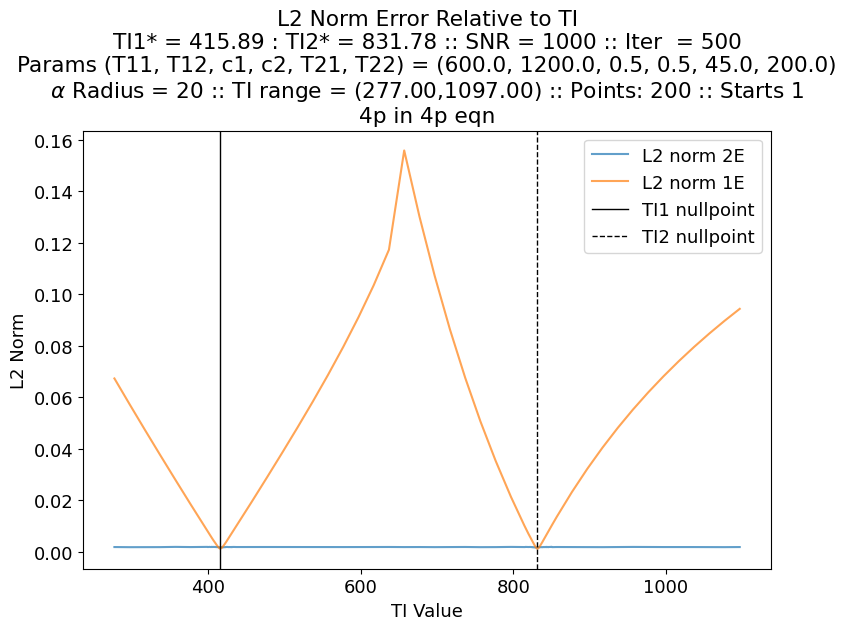

In [35]:
Err_avg = np.mean(errStore_2E,axis = 1)
Err_avg_1E = np.mean(errStore_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,Err_avg, label = 'L2 norm 2E', alpha = 0.7)
plt.plot(TI_array,Err_avg_1E, label = 'L2 norm 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('L2 Norm')
plt.title('L2 Norm Error Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

Biexponential Information at TI1 nullpoint :: RSS = 6.05e-05 :: AIC d term = 8.00e-06 :: BIC d term = 1.66e-05
Monoexponential Information at TI1 nullpoint :: RSS = 6.24e-05 :: AIC d term = 4.00e-06 :: BIC d term = 8.32e-06
Difference at TI1 nullpoint :: RSS = -1.88e-06 :: AIC d term = -4.00e-06 :: BIC d term = -8.32e-06


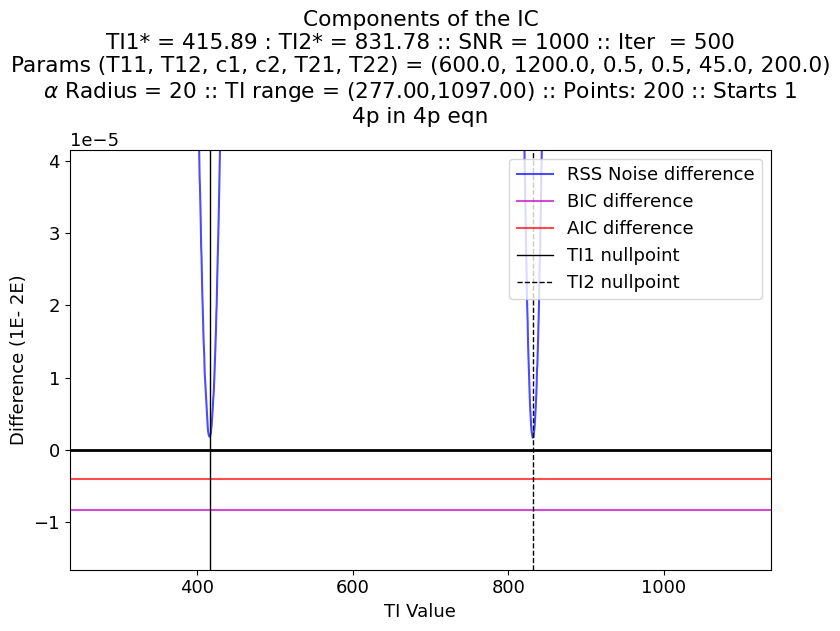

In [36]:
if RSS_noise_opt:
    RSS_avg_2E = np.mean(RSS_Noise_Store_2E,axis = 1)
    RSS_avg_1E = np.mean(RSS_Noise_Store_1E,axis = 1)
    label_RSS = "RSS Noise difference"
else:
    RSS_avg_2E = np.mean(RSS_Store_2E,axis = 1)
    RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
    label_RSS = "RSS True difference"

TI1_index = np.argmin((TI_array-TI1star)**2)

RSS_2E = RSS_avg_2E[TI1_index] 
RSS_1E = RSS_avg_1E[TI1_index] 
RSS_diff = RSS_2E - RSS_1E

AIC_2E_d = 2 * np.size(estParams)*noiseSigma**2
BIC_2E_d = np.log(TE_series.shape[0]) * np.size(estParams)*noiseSigma**2

AIC_1E_d = 2 * np.size(MonoTitle)*noiseSigma**2
BIC_1E_d = np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2

BIC_diff_d = BIC_1E_d - BIC_2E_d
AIC_diff_d = AIC_1E_d - AIC_2E_d

print("Biexponential Information at TI1 nullpoint :: RSS = " + "{:.2e}".format(RSS_2E) + " :: AIC d term = " + "{:.2e}".format(AIC_2E_d) + " :: BIC d term = " + "{:.2e}".format(BIC_2E_d))
print("Monoexponential Information at TI1 nullpoint :: RSS = " + "{:.2e}".format(RSS_1E) + " :: AIC d term = " + "{:.2e}".format(AIC_1E_d) + " :: BIC d term = " + "{:.2e}".format(BIC_1E_d))
print("Difference at TI1 nullpoint :: RSS = " + "{:.2e}".format(RSS_diff) + " :: AIC d term = " + "{:.2e}".format(AIC_diff_d) + " :: BIC d term = " + "{:.2e}".format(BIC_diff_d))


fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array, RSS_avg_1E - RSS_avg_2E, label = label_RSS, alpha = 0.7, color = 'b')
plt.axhline(y = BIC_diff_d, label = 'BIC difference', alpha = 0.7, color = 'm')
plt.axhline(y = AIC_diff_d, label = 'AIC difference', alpha = 0.7, color = 'r')
plt.axhline(y = 0, alpha = 1, color = 'k', linewidth=2)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('Difference (1E- 2E)')
plt.title('Components of the IC' + details)
plt.ylim([2*BIC_diff_d,-5*BIC_diff_d])
plt.legend()
plt.tight_layout()
plt.show()

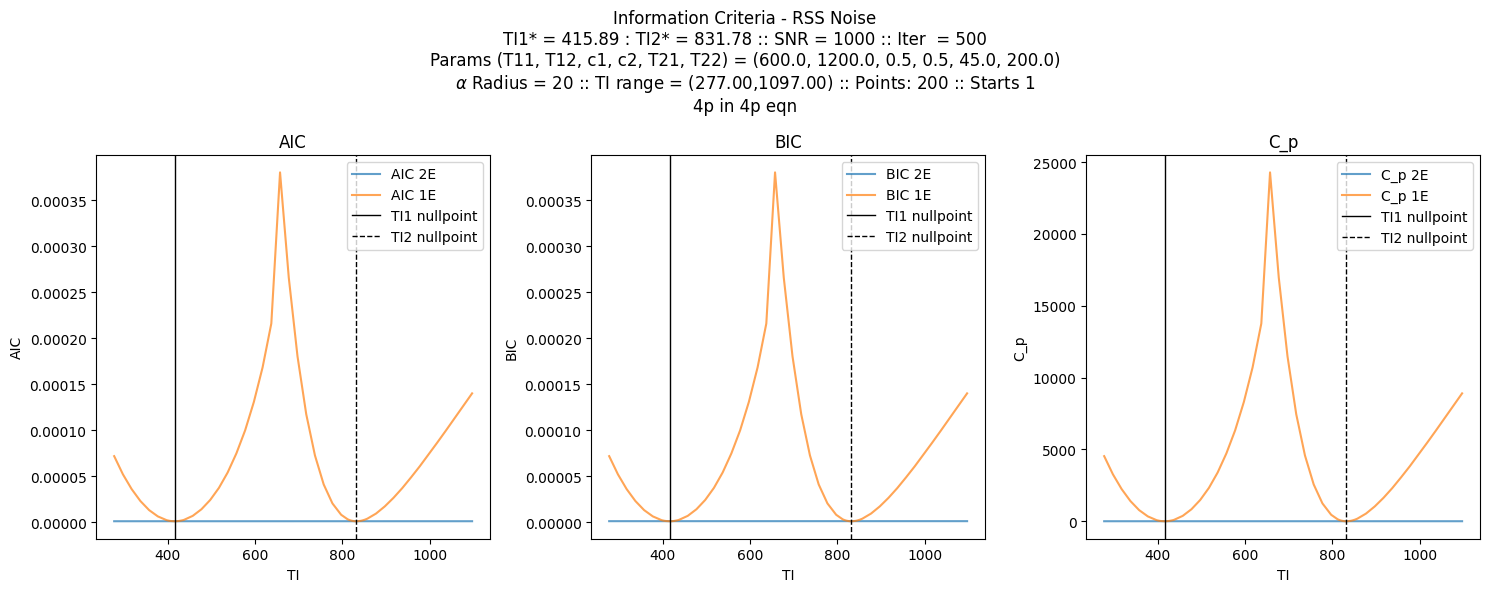

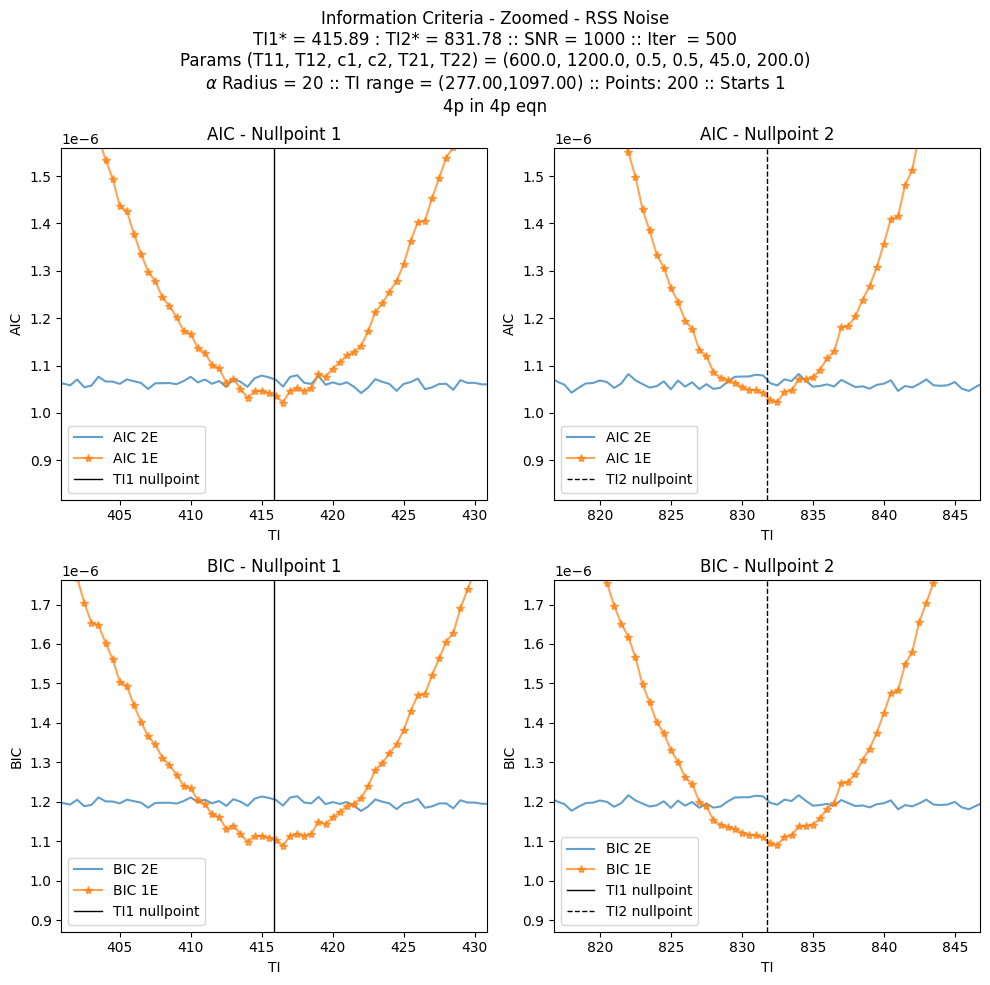

In [37]:
plt.rc('font', size = 10)
if RSS_noise_opt:
    RSS_avg_2E = np.mean(RSS_Noise_Store_2E,axis = 1)
    RSS_avg_1E = np.mean(RSS_Noise_Store_1E,axis = 1)
    label_RSS = "RSS Noise"
else:
    RSS_avg_2E = np.mean(RSS_Store_2E,axis = 1)
    RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
    label_RSS = "RSS True"

AIC_2E = 1/TE_series.shape[0] * (RSS_avg_2E + 2 * np.size(estParams)*noiseSigma**2)
AIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/TE_series.shape[0] * (RSS_avg_2E + np.log(TE_series.shape[0]) * np.size(estParams)*noiseSigma**2)
BIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg_2E/noiseSigma**2 + 2*np.size(estParams) - TE_series.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - TE_series.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria - ' + label_RSS + details)


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].legend()

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].legend()

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].legend()

fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
fig.suptitle('Information Criteria - Zoomed - ' + label_RSS + details)

minVal_1E = min(AIC_1E)
minVal_2E = min(AIC_2E)
ax[0,0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7, marker = "*")
ax[0,0].set_title('AIC - Nullpoint 1')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,0].set_xlabel('TI')
ax[0,0].set_ylabel('AIC')
ax[0,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,0].set_xlim([TI1star-rad, TI1star+rad])
ax[0,0].legend()

ax[0,1].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,1].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7, marker = "*")
ax[0,1].set_title('AIC - Nullpoint 2')
ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,1].set_xlabel('TI')
ax[0,1].set_ylabel('AIC')
ax[0,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,1].set_xlim([TI2star-rad, TI2star+rad])
ax[0,1].legend()

minVal_1E = min(BIC_1E)
minVal_2E = min(BIC_2E)
ax[1,0].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,0].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7, marker = "*")
ax[1,0].set_title('BIC - Nullpoint 1')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].set_xlabel('TI')
ax[1,0].set_ylabel('BIC')
ax[1,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,0].set_xlim([TI1star-rad, TI1star+rad])
ax[1,0].legend()

ax[1,1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7, marker = "*")
ax[1,1].set_title('BIC - Nullpoint 2')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1,1].set_xlabel('TI')
ax[1,1].set_ylabel('BIC')
ax[1,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,1].set_xlim([TI2star-rad, TI2star+rad])
ax[1,1].legend()


##### Official Figure - BIC

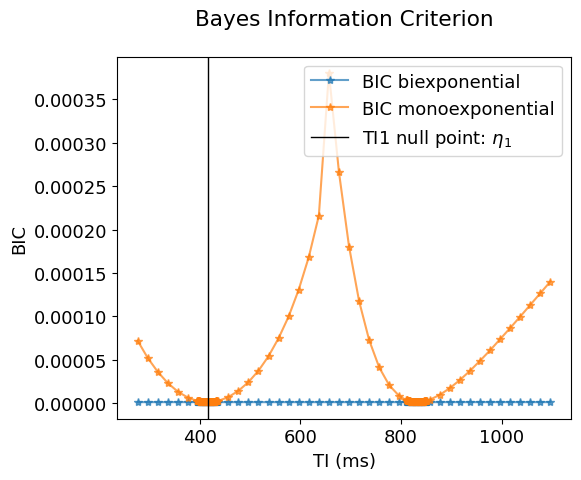

In [38]:
##################### Official Figure
fig= plt.figure(figsize=(6,5), tight_layout=True)
plt.rc('font', size = 13)

plt.plot(TI_array, BIC_2E, label = 'BIC biexponential', alpha = 0.7, marker = "*")
plt.plot(TI_array, BIC_1E, label = 'BIC monoexponential', alpha = 0.7, marker = "*")
plt.title('BIC')
plt.axvline(x=TI1star, linewidth=1, label= r'TI1 null point: $\eta_1$', color='k')
plt.xlabel('TI (ms)')
plt.ylabel('BIC')
plt.title('Bayes Information Criterion\n')
plt.legend()

### Rule-Breaking Plot

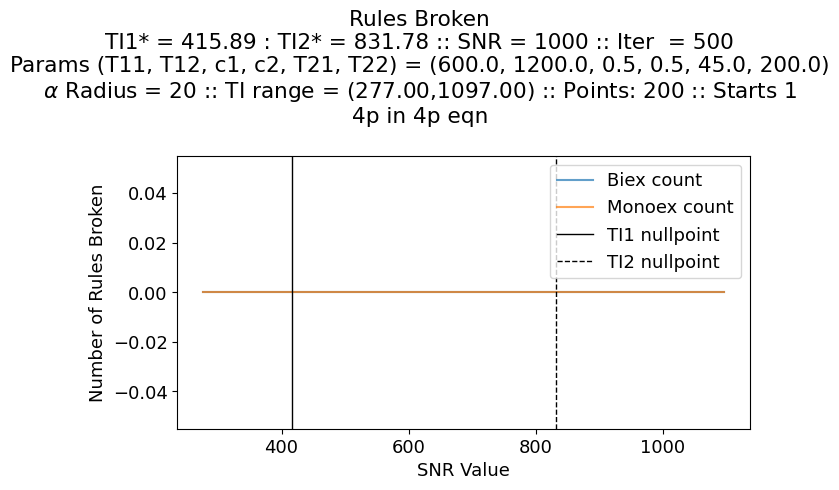

In [39]:
fig = plt.figure(figsize=(7,5), tight_layout=True)
fig.suptitle('Rules Broken' + details)
plt.plot(TI_array, numRuleBreak[:,0], label= 'Biex count', alpha = 0.7)
plt.plot(TI_array, numRuleBreak[:,1], label= 'Monoex count', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
if bothTI:
    plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('SNR Value')
plt.ylabel('Number of Rules Broken')
# plt.title('Biexponential Model')
plt.legend()
plt.show()

### Sensitivity Plots

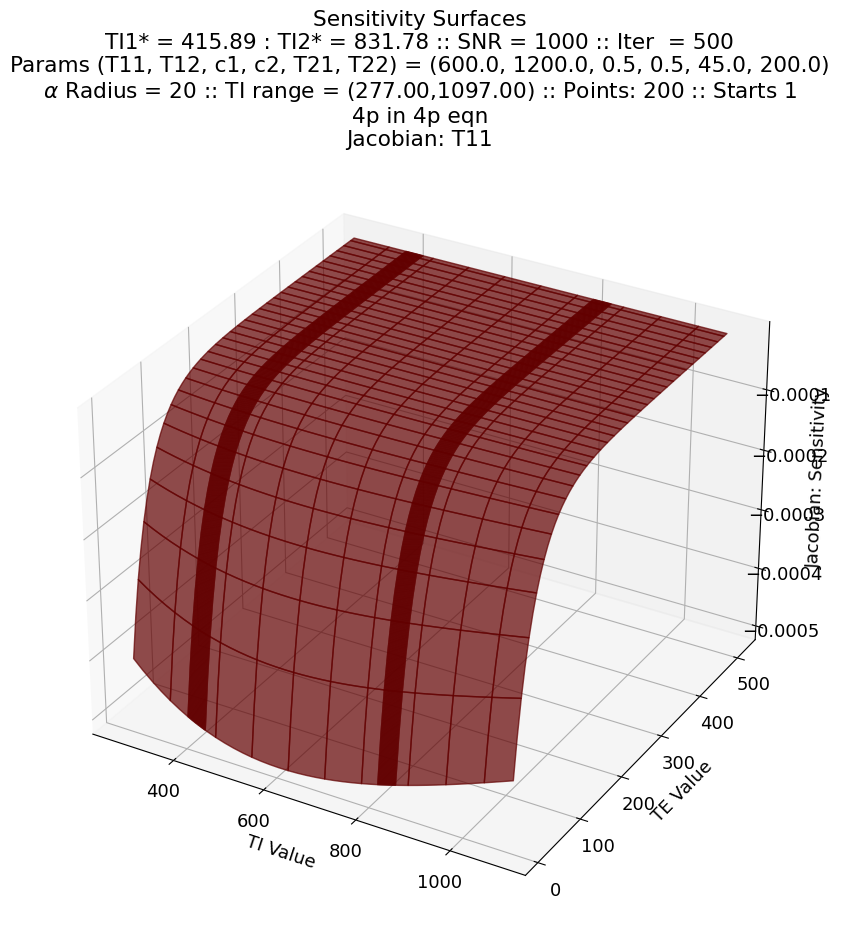

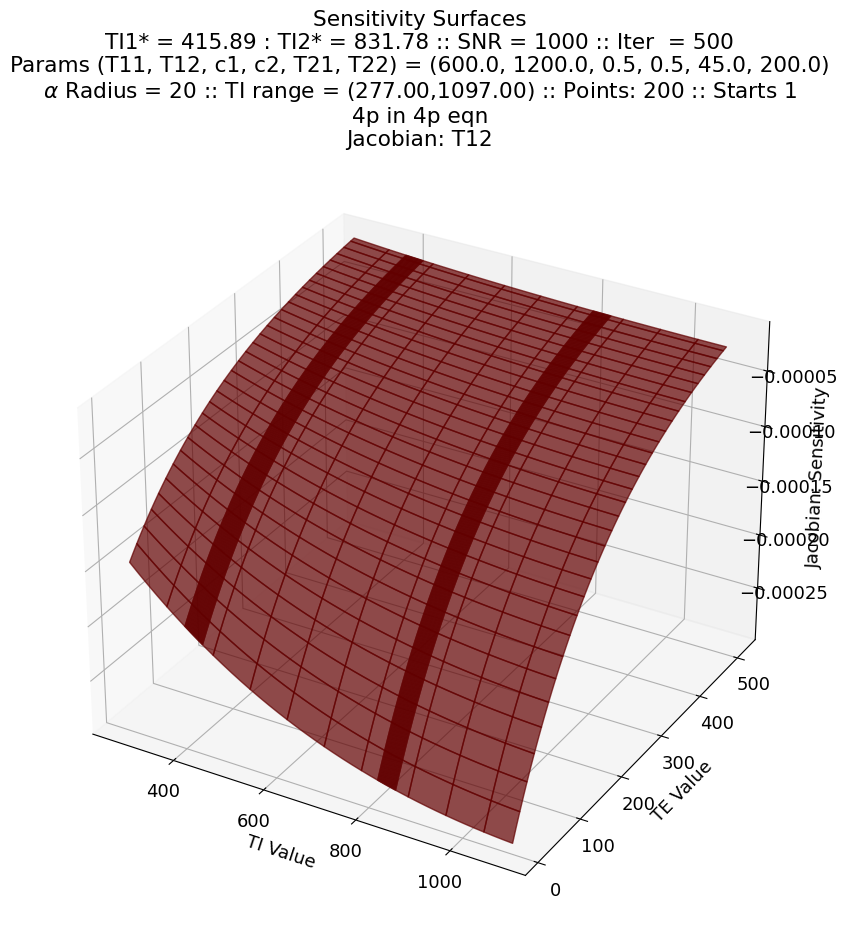

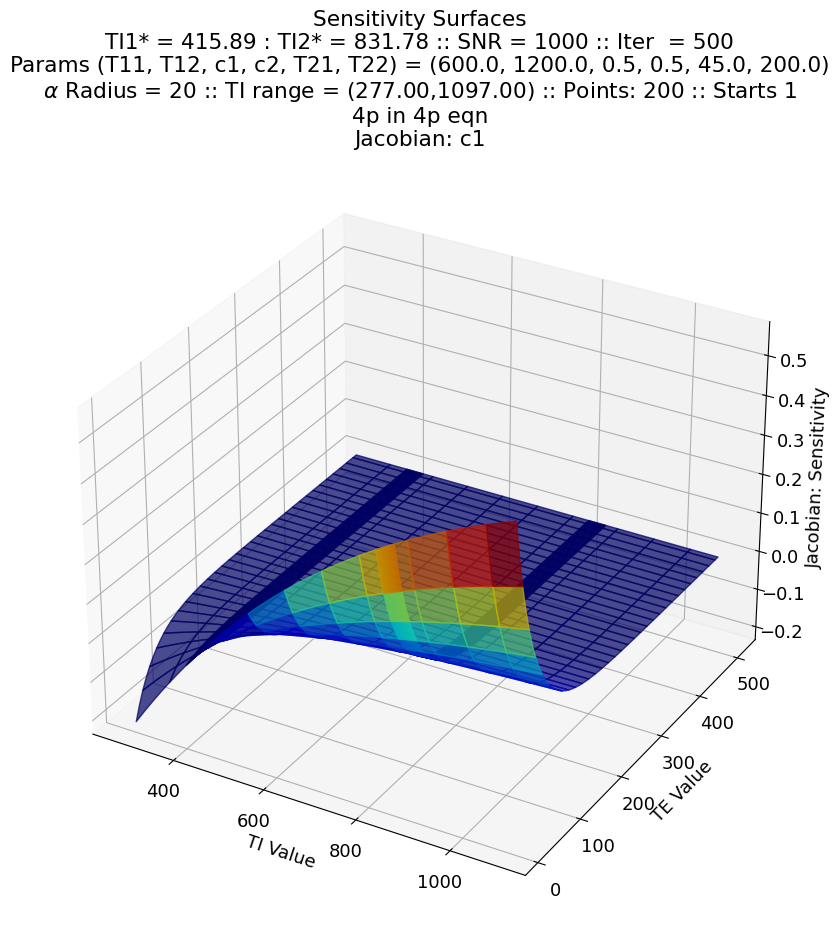

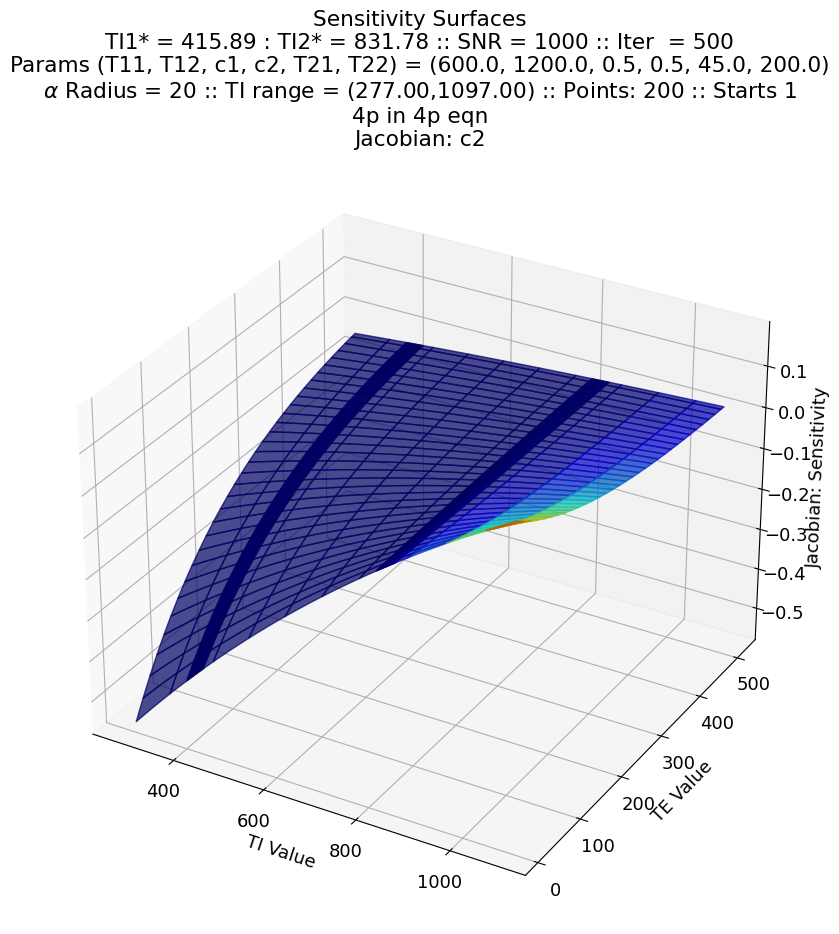

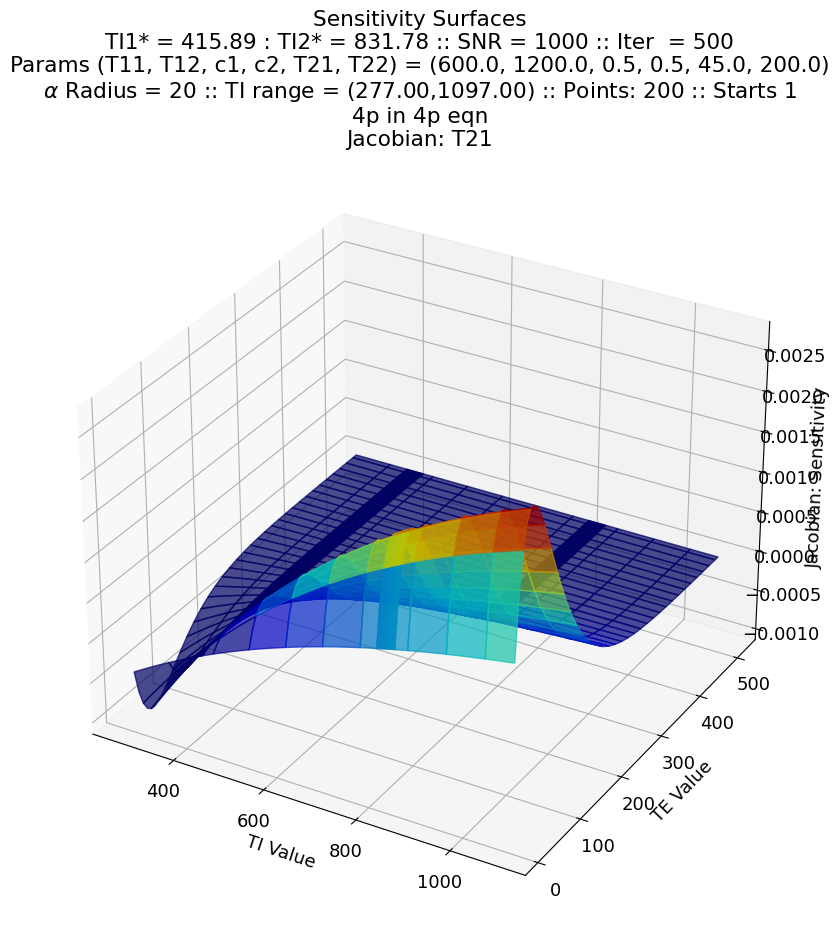

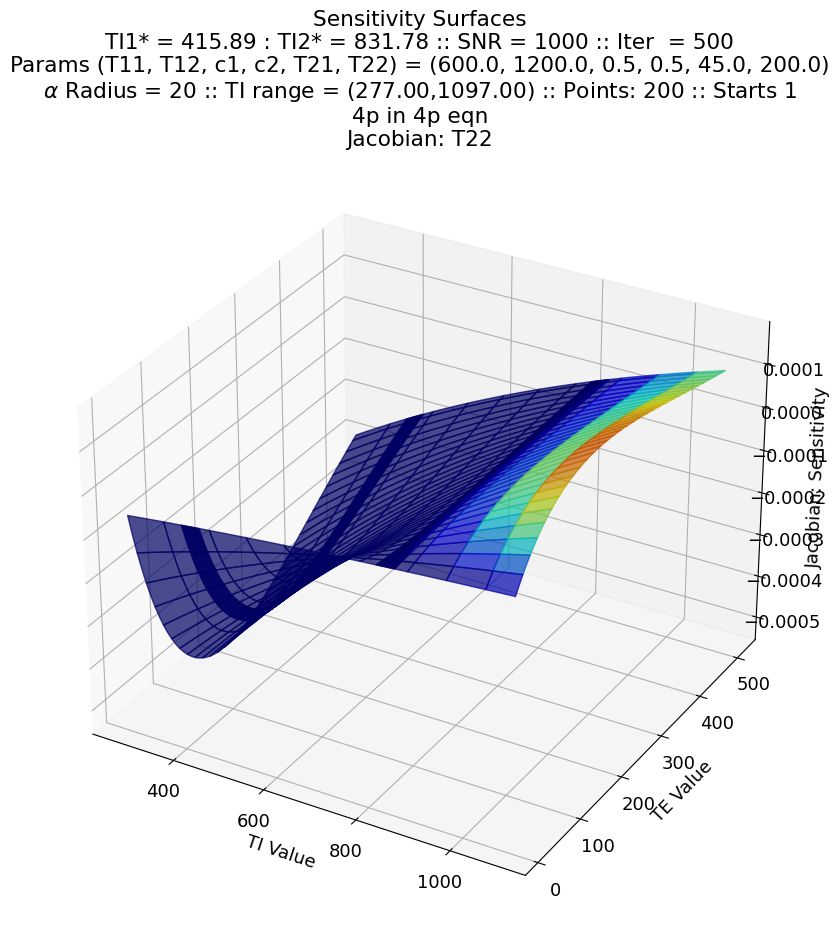

<Figure size 640x480 with 0 Axes>

In [40]:
dModel = False
TImg,TEmg = np.meshgrid(TI_array,TE_series)
avgPStore = np.mean(paramStore_2E, axis = 1)
if dModel:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_4p)))
else:
    Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_6p)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        if dModel:
            TI = TImg[i,j]
            d1 = d_value(TI,c1,T11)
            d2 = d_value(TI,c2,T12)
            Jstore[i,j,:] = Jacobian_4p(TEmg[i,j], d1, d2, T21, T22)
        else:
            Jstore[i,j,:] = Jacobian_6p(TEmg[i,j],TImg[i,j],T11,T12,c1,c2,T21,T22)
        
JacobianTitles = ["T11","T12","c1","c2","T21","T22"]


for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    my_col = cm.jet(Jstore[:,:,j]/np.amax(Jstore[:,:,j]))
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7, facecolors = my_col)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    if dModel:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + ParamTitle_4p[j])
    else:
        ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + JacobianTitles[j])
    plt.show()



plt.tight_layout()
plt.show()